In [ ]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from tqdm.auto import tqdm
from itertools import product

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# Directories
data_dir = os.path.join(os.getcwd(), '..', '..', 'localdata', 'data_for_python')

/Users/leo/Desktop/ResearchPhD/VNCMP/analysis_VNCMP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# To-do list:
Main:
- [X] Fix Xnoise vs X in trainers, make consistent
- [X] Implement precision functions


Low priority:
- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)
- [/] Parallel training with shared memory, fixed to have the right number of processes


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: mps


0.13590192794799805
Neurons (X): torch.Size([32, 3876107])
Muscles (Y): torch.Size([10, 3876107])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


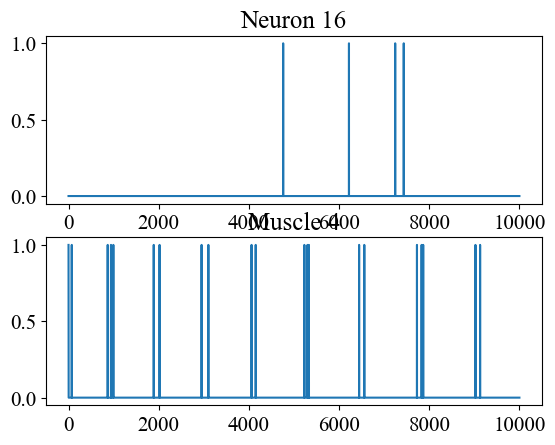

In [3]:
# Read the data and apply some binning/downsampling
period = 0.0001
tic = time.time()
X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
# Convert to torch tensors
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
print(time.time() - tic)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

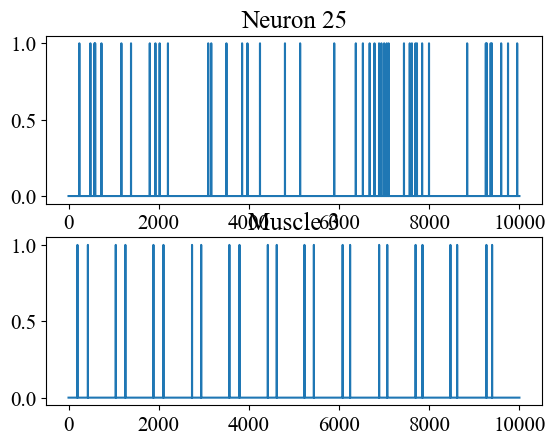

In [4]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 25
# idx = np.random.choice(torch.nonzero(Y[usemuscle,:] > 0)[0])
idx = np.random.choice(torch.nonzero(Y[usemuscle,:] > 0).flatten())
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

In [ ]:
torch.mps.empty_cache()
neuron = np.random.choice(X.shape[0])
neuron = 25
print(f'Neuron {neuron}')
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
# mis, mis_test, mod = train_cnn_model(dataset, this_params)
mis_test, train_id = train_cnn_model_no_eval(dataset, this_params, model_cache_dir)
mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id, burn_in=1)


Neuron 25
Train time = 5.775474786758423
Test time = 0.24387192726135254
Epoch: 1, DSIB, test: 0.001490626367740333
Train time = 3.781615972518921
Test time = 0.10401201248168945
Epoch: 2, DSIB, test: 0.0032741264440119267
Train time = 3.767526865005493
Test time = 0.1042170524597168
Epoch: 3, DSIB, test: 0.014530785381793976
Train time = 3.861485004425049
Test time = 0.10765218734741211
Epoch: 4, DSIB, test: 0.06576761603355408
Train time = 3.7685561180114746
Test time = 0.10485291481018066
Epoch: 5, DSIB, test: 0.07053261250257492
Train time = 3.777069091796875
Test time = 0.10352206230163574
Epoch: 6, DSIB, test: 0.07763534039258957
Train time = 3.770236015319824
Test time = 0.10445523262023926
Epoch: 7, DSIB, test: 0.06648082286119461
Train time = 3.7765591144561768
Test time = 0.10422706604003906
Epoch: 8, DSIB, test: 0.046533290296792984
Train time = 3.8732051849365234
Test time = 0.1546030044555664
Epoch: 9, DSIB, test: 0.10662282258272171
Train time = 3.8265159130096436
Test ti

Text(0, 0.5, 'MI')

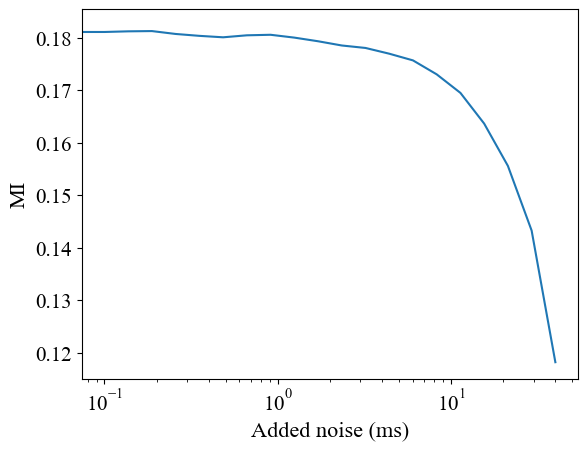

In [6]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3
with torch.no_grad():
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
    for j0,prec_noise_amp in enumerate(precision_noise_levels):
        for j1 in range(n_repeats):
            dataset.apply_noise(prec_noise_amp)
            precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
ax.set_xscale('log')
ax.set_xlabel('Added noise (ms)')
ax.set_ylabel('MI')

(0.0, 0.10468171461252496)

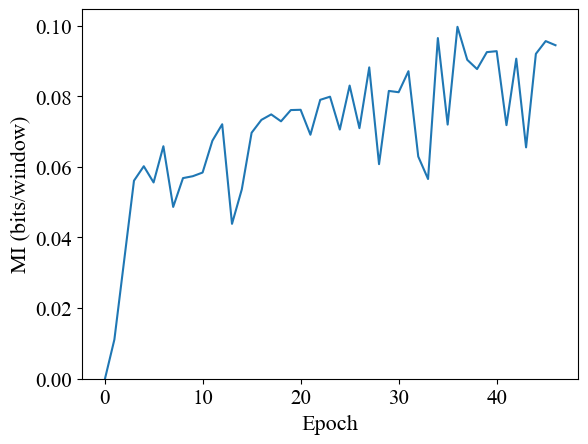

In [7]:
sigma = 1
# plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

# How much does network architecture matter?

Test of different architectures. Saves precision_mi curves for each

Vary across filters per layer (8, 16, 32), n_layers (4,5), stride (1, 2, 3)

All neurons, single neuron

Networks:
- Branched first layer: 3x3 + dilated 3x3, other layers are normal 3x3
- Completely branched, all layers. 
- Same all layers

Tonight: Run over all neurons as well, with 3 repeats
Also add network where dilated layers have dilation grow linearly

In [4]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': '1', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 1, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 32, # Number of new filters per layer. Each layer will 2x this number
    'layers': 4,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

In [19]:
import gc
total = 0
torch.mps.empty_cache()
for obj in gc.get_objects():
    try:
        # if (not isinstance(obj, torch.nn.parameter.Parameter)) and (torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data))):
        # if torch.is_tensor(obj) and not isinstance(obj, torch.nn.parameter.Parameter):
        print(type(obj), obj.size())
        # totalsize = np.sum(np.array([s for s in obj.size()]))
        if obj.nelement() < 1000:
            total += (obj.nelement() * obj.element_size())
    except:
        pass

<class 'jedi.inference.base_value.ValueSet'> S{}
<class '_pydevd_bundle.pydevd_constants.Null'> Null
<class '_pydevd_bundle.pydevd_constants.Null'> Null
<class 'unittest.mock._Call'> call.size()
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32, 3876107])
<class 'torch.Tensor'> torch.Size([10, 3876107])
<class 'torch.Tensor'> torch.Size([8493, 1])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.storage.UntypedStorage'> 496141696
<class 'torch.storage.UntypedStorage'> 155044280
<class 'torch.Tensor'> torch.Size([7570, 1, 1, 512])
<class 'torch.Tensor'> torch.Size([7570, 1, 10, 512])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([29095])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([98648])
<class 'torch.Tensor'> torch.Size([1,

In [15]:
import h5py

def save_dicts_to_hdf5(dicts, filename):
    with h5py.File(filename, 'w') as f:
        for i, d in enumerate(dicts):
            group = f.create_group(f'dict_{i}')
            
            for key, value in d.items():
                if isinstance(value, np.ndarray):
                    group.create_dataset(key, data=value)
                else:
                    # Store strings as fixed-length or variable-length
                    group.create_dataset(key, data=value)
def load_dicts_from_hdf5(filename):
    dicts = []
    with h5py.File(filename, 'r') as f:
        for group_name in f.keys():
            group = f[group_name]
            d = {}
            for key in group.keys():
                dataset = group[key]
                if dataset.dtype.char == 'S':  # String data
                    d[key] = dataset[()].decode('utf-8') if isinstance(dataset[()], bytes) else dataset[()]
                else:  # Numeric data
                    d[key] = dataset[:]
            dicts.append(d)
    return dicts

result_dir = os.path.join(data_dir, 'estimation_runs')
os.makedirs(result_dir, exist_ok=True)
save_dicts_to_hdf5(
    [train_ids, precision_curves, time_per_epoch],
    os.path.join(result_dir, 'network_arch_comparison_' + datetime.today().strftime('%Y-%m-%d') + '.h5')
)


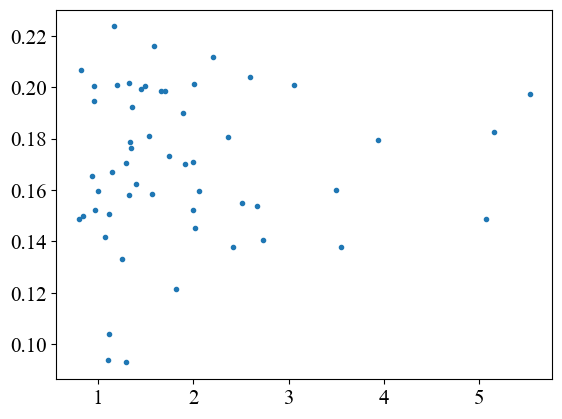

In [34]:
def load_dicts_from_hdf5(filename):
    dicts = []
    with h5py.File(filename, 'r') as f:
        for group_name in f.keys():
            group = f[group_name]
            d = {}
            for key in group.keys():
                dataset = group[key]
                if dataset.dtype.char == 'S':  # String data
                    d[key] = dataset[()].decode('utf-8') if isinstance(dataset[()], bytes) else dataset[()]
                else:  # Numeric data
                    d[key] = dataset[()]
            dicts.append(d)
    return dicts

fname = os.path.join(result_dir, 'network_arch_comparison_' + datetime.today().strftime('%Y-%m-%d') + '.h5')
bob = load_dicts_from_hdf5(fname)

times = np.array([bob[2][key] for key in bob[2].keys()])
MI = np.array([np.mean(bob[1][key][0,:]) for key in bob[1].keys()])
plt.plot(times, MI, '.')

Train time = 1.2325518131256104
Test time = 0.031713008880615234
Epoch: 1, DSIB, test: 0.018773576244711876
Train time = 0.9147548675537109
Test time = 0.018740177154541016
Epoch: 2, DSIB, test: 0.05321011319756508
Train time = 0.9402680397033691
Test time = 0.01898193359375
Epoch: 3, DSIB, test: 0.0714017003774643
Train time = 0.9272310733795166
Test time = 0.018763065338134766
Epoch: 4, DSIB, test: 0.062215011566877365
Train time = 0.9095909595489502
Test time = 0.018995285034179688
Epoch: 5, DSIB, test: 0.07442919909954071
Train time = 0.9090697765350342
Test time = 0.019835948944091797
Epoch: 6, DSIB, test: 0.08120211213827133
Train time = 0.9174349308013916
Test time = 0.01866006851196289
Epoch: 7, DSIB, test: 0.08089311420917511
Train time = 0.9183261394500732
Test time = 0.019845247268676758
Epoch: 8, DSIB, test: 0.08959277719259262
Train time = 0.9325370788574219
Test time = 0.01983809471130371
Epoch: 9, DSIB, test: 0.08177588880062103
Train time = 0.908574104309082
Test time =

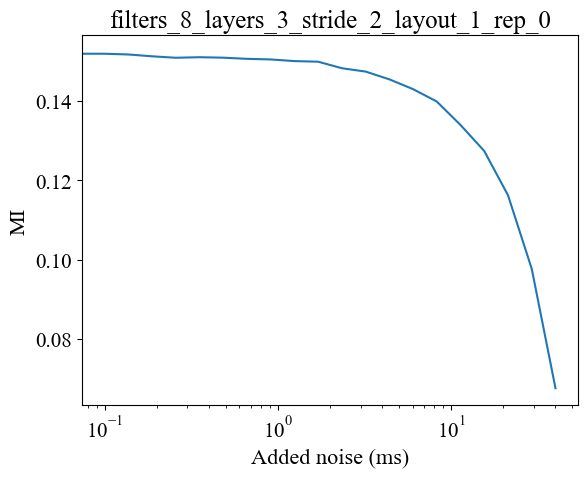

Train time = 1.3427629470825195
Test time = 0.04991006851196289
Epoch: 1, DSIB, test: 0.04205520451068878
Train time = 1.2846808433532715
Test time = 0.03880190849304199
Epoch: 2, DSIB, test: 0.05416485667228699
Train time = 1.3650779724121094
Test time = 0.03397989273071289
Epoch: 3, DSIB, test: 0.0684257447719574
Train time = 1.275559902191162
Test time = 0.02933192253112793
Epoch: 4, DSIB, test: 0.07911919057369232
Train time = 1.2349648475646973
Test time = 0.033248186111450195
Epoch: 5, DSIB, test: 0.08493845909833908
Train time = 1.2472009658813477
Test time = 0.02901482582092285
Epoch: 6, DSIB, test: 0.07249747216701508
Train time = 1.2358899116516113
Test time = 0.03374505043029785
Epoch: 7, DSIB, test: 0.08777091652154922
Train time = 1.2858269214630127
Test time = 0.027803897857666016
Epoch: 8, DSIB, test: 0.07665429264307022
Train time = 1.2294118404388428
Test time = 0.03554081916809082
Epoch: 9, DSIB, test: 0.09382014721632004
Train time = 1.2641170024871826
Test time = 0.

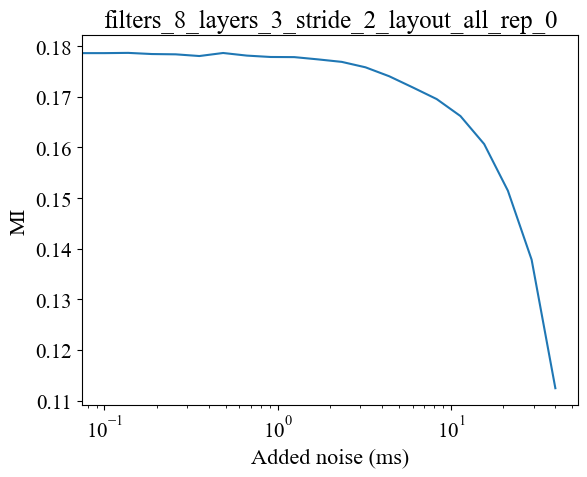

Train time = 0.7783491611480713
Test time = 0.01725602149963379
Epoch: 1, DSIB, test: 0.006116893608123064
Train time = 0.7741580009460449
Test time = 0.017132997512817383
Epoch: 2, DSIB, test: 0.02879050001502037
Train time = 0.7751479148864746
Test time = 0.017565011978149414
Epoch: 3, DSIB, test: 0.05928992107510567
Train time = 0.7676281929016113
Test time = 0.01773381233215332
Epoch: 4, DSIB, test: 0.0688193291425705
Train time = 0.7619209289550781
Test time = 0.017765045166015625
Epoch: 5, DSIB, test: 0.07450755685567856
Train time = 0.7529547214508057
Test time = 0.01700282096862793
Epoch: 6, DSIB, test: 0.06991899758577347
Train time = 0.8564767837524414
Test time = 0.014091968536376953
Epoch: 7, DSIB, test: 0.07609451562166214
Train time = 0.7595019340515137
Test time = 0.017619848251342773
Epoch: 8, DSIB, test: 0.060352109372615814
Train time = 0.7598080635070801
Test time = 0.0174100399017334
Epoch: 9, DSIB, test: 0.06979651004076004
Train time = 0.7722420692443848
Test time

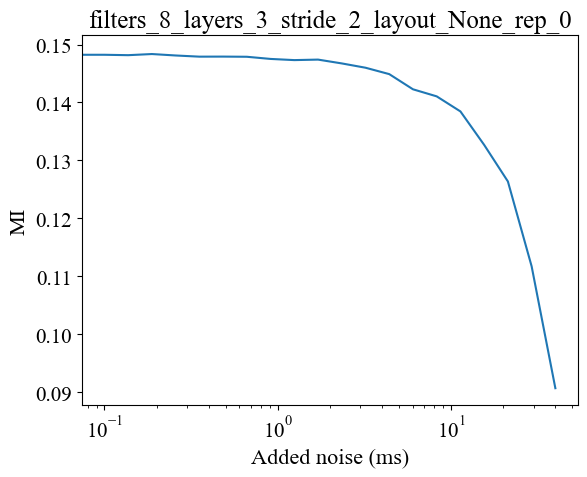

Train time = 0.939436674118042
Test time = 0.028389692306518555
Epoch: 1, DSIB, test: 0.03579390048980713
Train time = 0.8855469226837158
Test time = 0.01897716522216797
Epoch: 2, DSIB, test: 0.06409997493028641
Train time = 0.9029378890991211
Test time = 0.01992321014404297
Epoch: 3, DSIB, test: 0.0700722187757492
Train time = 0.9338009357452393
Test time = 0.01902604103088379
Epoch: 4, DSIB, test: 0.07725003361701965
Train time = 1.1204347610473633
Test time = 0.02657794952392578
Epoch: 5, DSIB, test: 0.07287602871656418
Train time = 0.9340791702270508
Test time = 0.018069982528686523
Epoch: 6, DSIB, test: 0.06460656225681305
Train time = 0.9632577896118164
Test time = 0.018304824829101562
Epoch: 7, DSIB, test: 0.0772845596075058
Train time = 0.9579360485076904
Test time = 0.020933151245117188
Epoch: 8, DSIB, test: 0.07648607343435287
Train time = 0.9752402305603027
Test time = 0.020944833755493164
Epoch: 9, DSIB, test: 0.09067429602146149
Train time = 0.941744327545166
Test time = 0

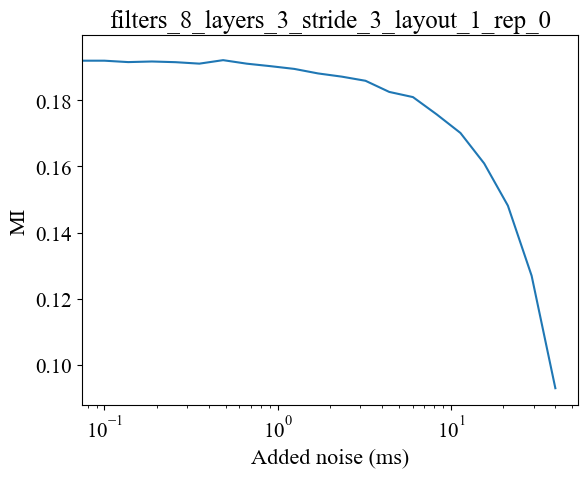

Train time = 1.3048009872436523
Test time = 0.04306221008300781
Epoch: 1, DSIB, test: 0.016874419525265694
Train time = 1.3098409175872803
Test time = 0.038763999938964844
Epoch: 2, DSIB, test: 0.04767220467329025
Train time = 1.356194019317627
Test time = 0.03414511680603027
Epoch: 3, DSIB, test: 0.050095200538635254
Train time = 1.3495309352874756
Test time = 0.032737016677856445
Epoch: 4, DSIB, test: 0.05553266406059265
Train time = 1.3459718227386475
Test time = 0.03267717361450195
Epoch: 5, DSIB, test: 0.06063931807875633
Train time = 1.2915630340576172
Test time = 0.02829432487487793
Epoch: 6, DSIB, test: 0.05656943470239639
Train time = 1.2645978927612305
Test time = 0.033061981201171875
Epoch: 7, DSIB, test: 0.0805780291557312
Train time = 1.2516629695892334
Test time = 0.029955148696899414
Epoch: 8, DSIB, test: 0.08219839632511139
Train time = 1.3723609447479248
Test time = 0.03341388702392578
Epoch: 9, DSIB, test: 0.06208505854010582
Train time = 1.4980227947235107
Test time 

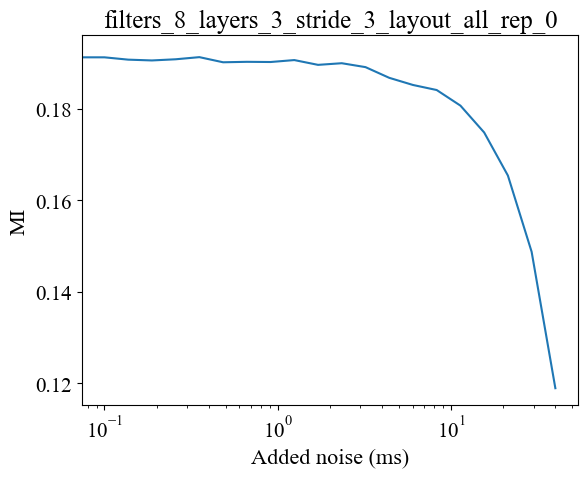

Train time = 0.8242850303649902
Test time = 0.017477989196777344
Epoch: 1, DSIB, test: 0.026469269767403603
Train time = 0.8138329982757568
Test time = 0.017342805862426758
Epoch: 2, DSIB, test: 0.05276642367243767
Train time = 0.8072676658630371
Test time = 0.015133857727050781
Epoch: 3, DSIB, test: 0.04557118937373161
Train time = 0.7557849884033203
Test time = 0.016319990158081055
Epoch: 4, DSIB, test: 0.05114069953560829
Train time = 0.7567999362945557
Test time = 0.017045974731445312
Epoch: 5, DSIB, test: 0.058855317533016205
Train time = 0.776885986328125
Test time = 0.015239238739013672
Epoch: 6, DSIB, test: 0.03856370598077774
Train time = 0.7589669227600098
Test time = 0.015604972839355469
Epoch: 7, DSIB, test: 0.0508352592587471
Train time = 0.7787861824035645
Test time = 0.016208887100219727
Epoch: 8, DSIB, test: 0.05734914913773537
Train time = 0.7824909687042236
Test time = 0.016875028610229492
Epoch: 9, DSIB, test: 0.06890713423490524
Train time = 0.8127632141113281
Test 

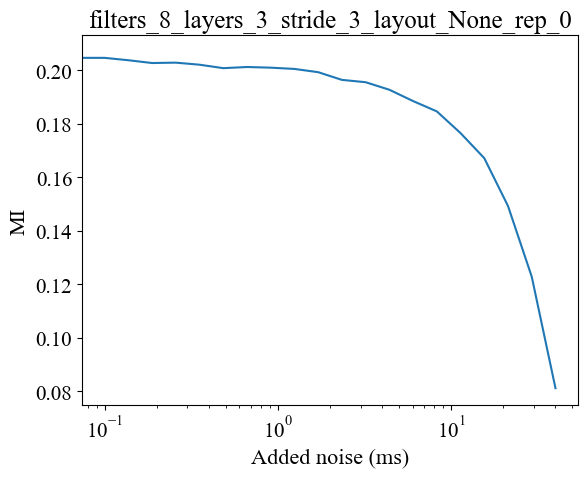

Train time = 1.161512851715088
Test time = 0.029252052307128906
Epoch: 1, DSIB, test: 0.0012867284240201116
Train time = 1.1034481525421143
Test time = 0.025336265563964844
Epoch: 2, DSIB, test: -0.0034273075871169567
Train time = 1.117476224899292
Test time = 0.022382020950317383
Epoch: 3, DSIB, test: 0.045548345893621445
Train time = 1.1098182201385498
Test time = 0.02149510383605957
Epoch: 4, DSIB, test: 0.060083553194999695
Train time = 1.0800812244415283
Test time = 0.022401094436645508
Epoch: 5, DSIB, test: 0.04569711908698082
Train time = 1.118992805480957
Test time = 0.021899938583374023
Epoch: 6, DSIB, test: 0.058433230966329575
Train time = 1.0931811332702637
Test time = 0.022371768951416016
Epoch: 7, DSIB, test: 0.05910925194621086
Train time = 1.108731985092163
Test time = 0.02324199676513672
Epoch: 8, DSIB, test: 0.07389604300260544
Train time = 1.0733709335327148
Test time = 0.024058818817138672
Epoch: 9, DSIB, test: 0.08464235812425613
Train time = 1.096095085144043
Test

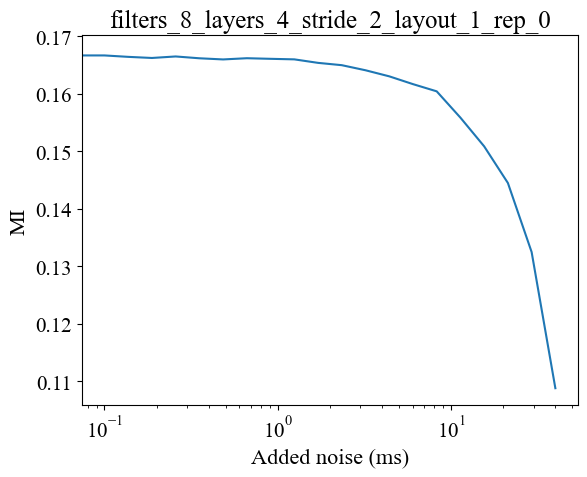

Train time = 1.6043901443481445
Test time = 0.05874896049499512
Epoch: 1, DSIB, test: 0.038998592644929886
Train time = 1.5375549793243408
Test time = 0.054121971130371094
Epoch: 2, DSIB, test: 0.029300473630428314
Train time = 1.5334489345550537
Test time = 0.05453205108642578
Epoch: 3, DSIB, test: 0.08227456361055374
Train time = 1.5380029678344727
Test time = 0.054659128189086914
Epoch: 4, DSIB, test: 0.09203221648931503
Train time = 1.4958350658416748
Test time = 0.05330085754394531
Epoch: 5, DSIB, test: 0.08944687992334366
Train time = 1.5486741065979004
Test time = 0.05454683303833008
Epoch: 6, DSIB, test: 0.12049242109060287
Train time = 1.540020227432251
Test time = 0.05439400672912598
Epoch: 7, DSIB, test: 0.11536002159118652
Train time = 1.4920179843902588
Test time = 0.053344011306762695
Epoch: 8, DSIB, test: 0.130677729845047
Train time = 1.4871399402618408
Test time = 0.05625200271606445
Epoch: 9, DSIB, test: 0.13990779221057892
Train time = 1.5224192142486572
Test time = 

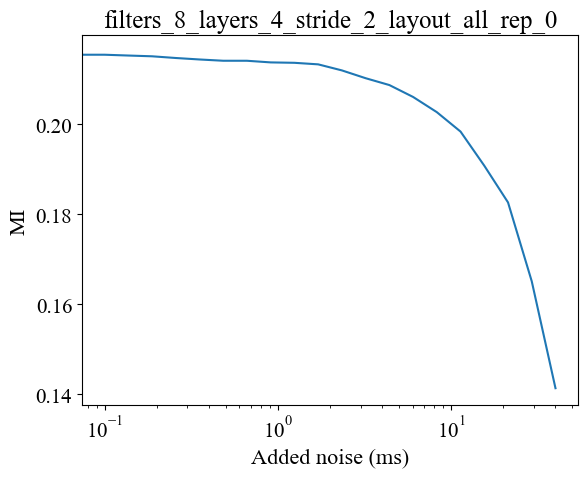

Train time = 0.9406280517578125
Test time = 0.021617889404296875
Epoch: 1, DSIB, test: 0.005328419618308544
Train time = 0.8892021179199219
Test time = 0.01993393898010254
Epoch: 2, DSIB, test: 0.05586446076631546
Train time = 0.9029712677001953
Test time = 0.020080089569091797
Epoch: 3, DSIB, test: 0.09238268435001373
Train time = 0.9047870635986328
Test time = 0.019626855850219727
Epoch: 4, DSIB, test: 0.09049796313047409
Train time = 0.9292991161346436
Test time = 0.021306753158569336
Epoch: 5, DSIB, test: 0.09412060678005219
Train time = 0.9146981239318848
Test time = 0.021959781646728516
Epoch: 6, DSIB, test: 0.09443724155426025
Train time = 0.9128808975219727
Test time = 0.021863937377929688
Epoch: 7, DSIB, test: 0.1251652091741562
Train time = 0.9093449115753174
Test time = 0.018798112869262695
Epoch: 8, DSIB, test: 0.12734189629554749
Train time = 0.9355978965759277
Test time = 0.021053791046142578
Epoch: 9, DSIB, test: 0.1417476385831833
Train time = 0.9400339126586914
Test ti

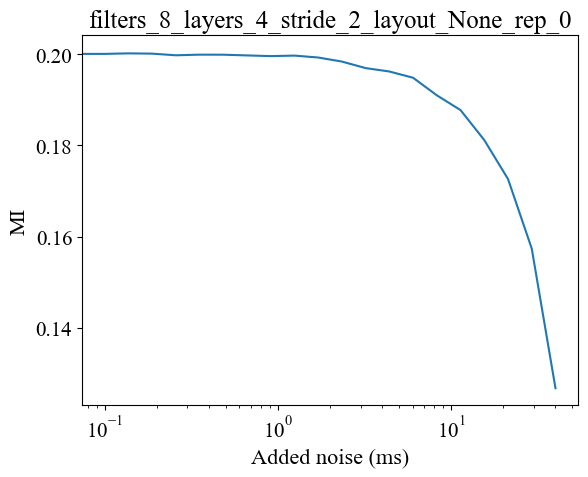

Train time = 1.1275370121002197
Test time = 0.027331829071044922
Epoch: 1, DSIB, test: 0.005012214183807373
Train time = 1.0702011585235596
Test time = 0.02520895004272461
Epoch: 2, DSIB, test: 0.05006477236747742
Train time = 1.0111172199249268
Test time = 0.05718994140625
Epoch: 3, DSIB, test: 0.03569614142179489
Train time = 1.0446958541870117
Test time = 0.03223705291748047
Epoch: 4, DSIB, test: 0.046312734484672546
Train time = 1.0180890560150146
Test time = 0.05655980110168457
Epoch: 5, DSIB, test: 0.062454335391521454
Train time = 1.1568667888641357
Test time = 0.021641016006469727
Epoch: 6, DSIB, test: 0.05008247122168541
Train time = 1.0656979084014893
Test time = 0.024164199829101562
Epoch: 7, DSIB, test: 0.06380343437194824
Train time = 1.065319299697876
Test time = 0.023529052734375
Epoch: 8, DSIB, test: 0.02930741384625435
Train time = 1.0743517875671387
Test time = 0.023643970489501953
Epoch: 9, DSIB, test: 0.02346138097345829
Train time = 1.067507028579712
Test time = 0.

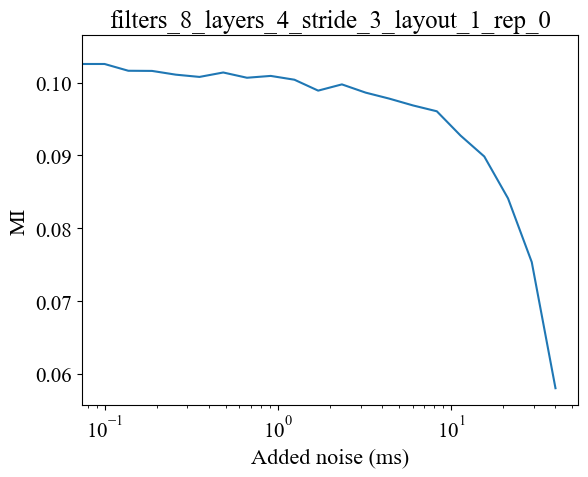

Train time = 1.4866437911987305
Test time = 0.04592490196228027
Epoch: 1, DSIB, test: 0.00418896647170186
Train time = 1.4961857795715332
Test time = 0.04217195510864258
Epoch: 2, DSIB, test: 0.052846431732177734
Train time = 1.4590668678283691
Test time = 0.04247307777404785
Epoch: 3, DSIB, test: 0.0604063905775547
Train time = 1.4646220207214355
Test time = 0.04173612594604492
Epoch: 4, DSIB, test: 0.06461526453495026
Train time = 1.4644579887390137
Test time = 0.0408940315246582
Epoch: 5, DSIB, test: 0.0668700709939003
Train time = 1.4360692501068115
Test time = 0.04145097732543945
Epoch: 6, DSIB, test: 0.07906065136194229
Train time = 1.43556809425354
Test time = 0.041545867919921875
Epoch: 7, DSIB, test: 0.06287995725870132
Train time = 1.4301607608795166
Test time = 0.04013204574584961
Epoch: 8, DSIB, test: 0.08179344236850739
Train time = 1.4604856967926025
Test time = 0.04153609275817871
Epoch: 9, DSIB, test: 0.07924322783946991
Train time = 1.456913948059082
Test time = 0.0436

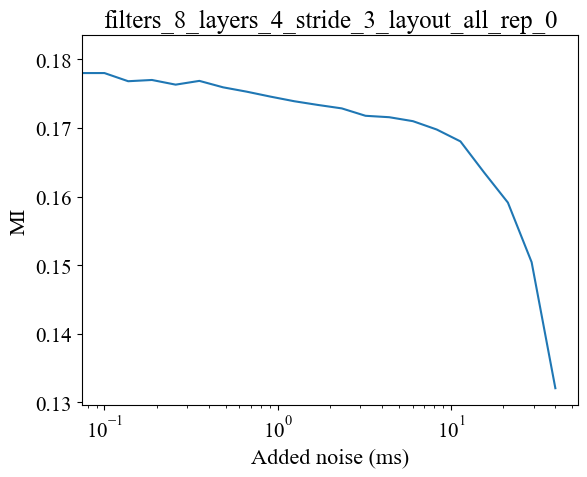

Train time = 0.8978376388549805
Test time = 0.01916813850402832
Epoch: 1, DSIB, test: 0.004328735172748566
Train time = 0.9152188301086426
Test time = 0.018666982650756836
Epoch: 2, DSIB, test: 0.024016503244638443
Train time = 0.894970178604126
Test time = 0.019170045852661133
Epoch: 3, DSIB, test: 0.05818583816289902
Train time = 0.8793511390686035
Test time = 0.020138978958129883
Epoch: 4, DSIB, test: 0.06633614748716354
Train time = 0.9009490013122559
Test time = 0.017914772033691406
Epoch: 5, DSIB, test: 0.054100554436445236
Train time = 0.8794469833374023
Test time = 0.01851511001586914
Epoch: 6, DSIB, test: 0.06046604737639427
Train time = 0.886206865310669
Test time = 0.02043294906616211
Epoch: 7, DSIB, test: 0.07925962656736374
Train time = 0.8959732055664062
Test time = 0.019474267959594727
Epoch: 8, DSIB, test: 0.07011552900075912
Train time = 0.8892910480499268
Test time = 0.019086122512817383
Epoch: 9, DSIB, test: 0.06790077686309814
Train time = 0.8966689109802246
Test ti

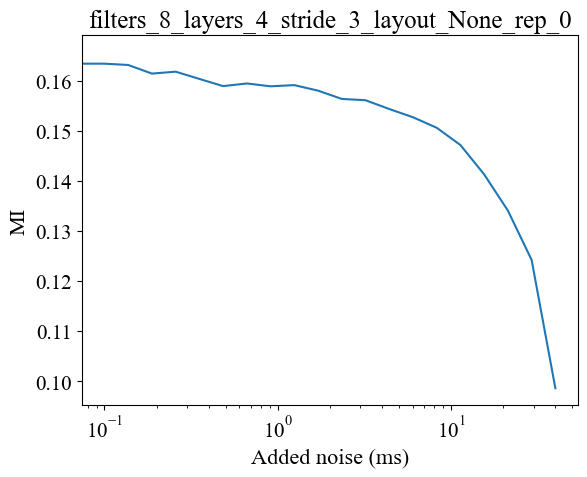

Train time = 1.2550289630889893
Test time = 0.028918981552124023
Epoch: 1, DSIB, test: 0.002481384901329875
Train time = 1.2158870697021484
Test time = 0.024466991424560547
Epoch: 2, DSIB, test: 0.0034381295554339886
Train time = 1.2878878116607666
Test time = 0.024998188018798828
Epoch: 3, DSIB, test: 0.001121393172070384
Train time = 1.1977300643920898
Test time = 0.024600982666015625
Epoch: 4, DSIB, test: 0.04216957837343216
Train time = 1.2179100513458252
Test time = 0.026957035064697266
Epoch: 5, DSIB, test: 0.06799913942813873
Train time = 1.223261833190918
Test time = 0.02387714385986328
Epoch: 6, DSIB, test: 0.06971482932567596
Train time = 1.225714921951294
Test time = 0.02301311492919922
Epoch: 7, DSIB, test: 0.11372721940279007
Train time = 1.212764024734497
Test time = 0.022912025451660156
Epoch: 8, DSIB, test: 0.1331220120191574
Train time = 1.214128017425537
Test time = 0.02357196807861328
Epoch: 9, DSIB, test: 0.11463553458452225
Train time = 1.2077479362487793
Test time

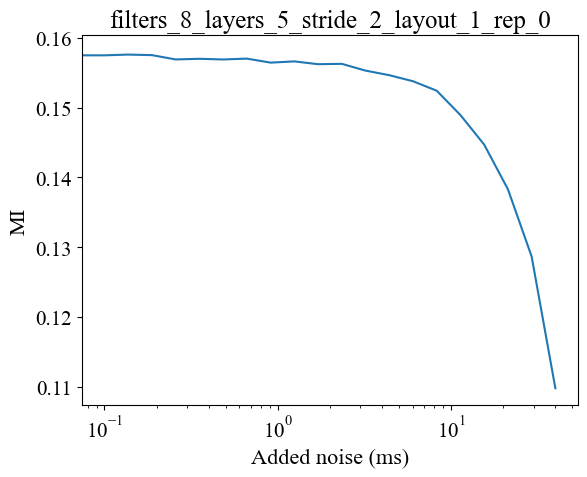

Train time = 1.9461300373077393
Test time = 0.07421493530273438
Epoch: 1, DSIB, test: 0.0022860411554574966
Train time = 1.9274611473083496
Test time = 0.06692790985107422
Epoch: 2, DSIB, test: -0.00024196115555241704
Train time = 1.9951050281524658
Test time = 0.0794990062713623
Epoch: 3, DSIB, test: 0.035618655383586884
Train time = 2.0046589374542236
Test time = 0.07178902626037598
Epoch: 4, DSIB, test: 0.08426565676927567
Train time = 1.956057071685791
Test time = 0.06785798072814941
Epoch: 5, DSIB, test: 0.08999365568161011
Train time = 2.096168279647827
Test time = 0.06650805473327637
Epoch: 6, DSIB, test: 0.09502287209033966
Train time = 1.9236042499542236
Test time = 0.06501984596252441
Epoch: 7, DSIB, test: 0.08325310051441193
Train time = 1.9496848583221436
Test time = 0.06554913520812988
Epoch: 8, DSIB, test: 0.10513319820165634
Train time = 1.9225242137908936
Test time = 0.0662527084350586
Epoch: 9, DSIB, test: 0.12516522407531738
Train time = 1.932657241821289
Test time = 

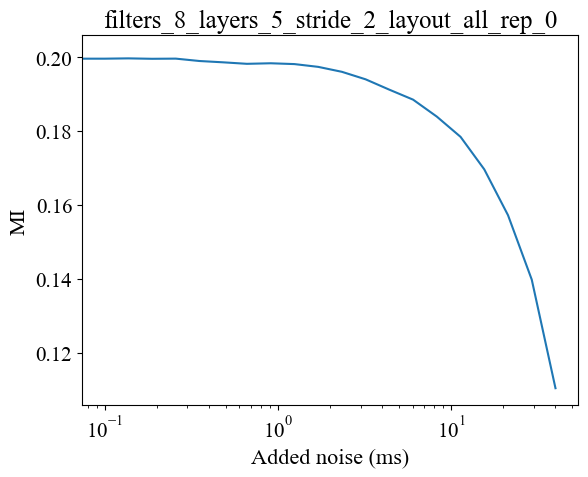

Train time = 1.1428909301757812
Test time = 0.022572040557861328
Epoch: 1, DSIB, test: 0.012585011310875416
Train time = 1.1269357204437256
Test time = 0.0231020450592041
Epoch: 2, DSIB, test: 0.01673624850809574
Train time = 1.1038100719451904
Test time = 0.022758007049560547
Epoch: 3, DSIB, test: 0.05383741855621338
Train time = 1.1283979415893555
Test time = 0.02366328239440918
Epoch: 4, DSIB, test: 0.05855807662010193
Train time = 1.1150341033935547
Test time = 0.02530813217163086
Epoch: 5, DSIB, test: 0.08203021436929703
Train time = 1.1279418468475342
Test time = 0.025490999221801758
Epoch: 6, DSIB, test: 0.09101446717977524
Train time = 1.1010398864746094
Test time = 0.024309873580932617
Epoch: 7, DSIB, test: 0.0700133740901947
Train time = 1.115760087966919
Test time = 0.023315906524658203
Epoch: 8, DSIB, test: 0.07265584915876389
Train time = 1.123067855834961
Test time = 0.02273392677307129
Epoch: 9, DSIB, test: 0.0725921243429184
Train time = 1.1465981006622314
Test time = 0

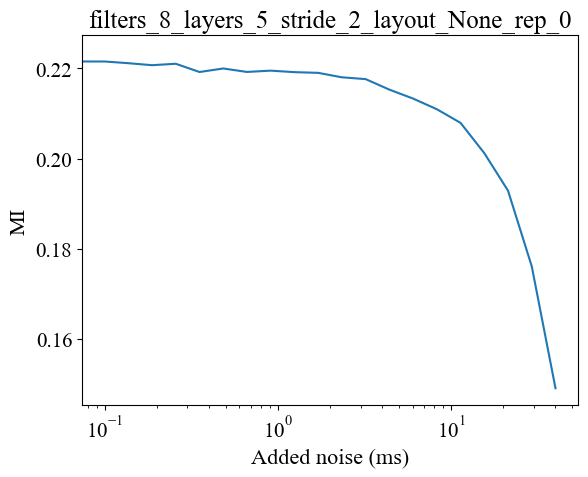

Train time = 1.2286410331726074
Test time = 0.03216099739074707
Epoch: 1, DSIB, test: 0.00692363828420639
Train time = 1.1933510303497314
Test time = 0.023688077926635742
Epoch: 2, DSIB, test: 0.02578658238053322
Train time = 1.201362133026123
Test time = 0.02489614486694336
Epoch: 3, DSIB, test: 0.037809181958436966
Train time = 1.2013978958129883
Test time = 0.02218174934387207
Epoch: 4, DSIB, test: 0.04788883402943611
Train time = 1.1858432292938232
Test time = 0.02266716957092285
Epoch: 5, DSIB, test: 0.05447603389620781
Train time = 1.199429988861084
Test time = 0.023267745971679688
Epoch: 6, DSIB, test: 0.05520922690629959
Train time = 1.2400970458984375
Test time = 0.023670196533203125
Epoch: 7, DSIB, test: 0.056862376630306244
Train time = 1.2300479412078857
Test time = 0.02244114875793457
Epoch: 8, DSIB, test: 0.044598668813705444
Train time = 1.2015941143035889
Test time = 0.02412700653076172
Epoch: 9, DSIB, test: 0.013617627322673798
Train time = 1.2552707195281982
Test time

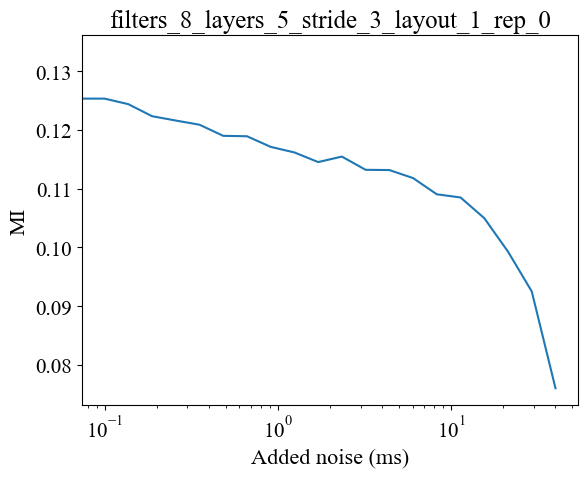

Train time = 1.8672540187835693
Test time = 0.05703091621398926
Epoch: 1, DSIB, test: 0.02695322036743164
Train time = 1.7413220405578613
Test time = 0.060067176818847656
Epoch: 2, DSIB, test: 0.03727543354034424
Train time = 1.7161848545074463
Test time = 0.05915379524230957
Epoch: 3, DSIB, test: 0.06327720731496811
Train time = 1.7135210037231445
Test time = 0.05860018730163574
Epoch: 4, DSIB, test: 0.05882754176855087
Train time = 1.719632863998413
Test time = 0.06130623817443848
Epoch: 5, DSIB, test: 0.07117889821529388
Train time = 1.7251019477844238
Test time = 0.060720205307006836
Epoch: 6, DSIB, test: 0.06399539858102798
Train time = 1.7216613292694092
Test time = 0.05940890312194824
Epoch: 7, DSIB, test: 0.003108132863417268
Train time = 1.6913321018218994
Test time = 0.05831193923950195
Epoch: 8, DSIB, test: 0.06189616397023201
Train time = 1.7329018115997314
Test time = 0.06045174598693848
Epoch: 9, DSIB, test: -0.03931368142366409
Train time = 1.7450790405273438
Test time =

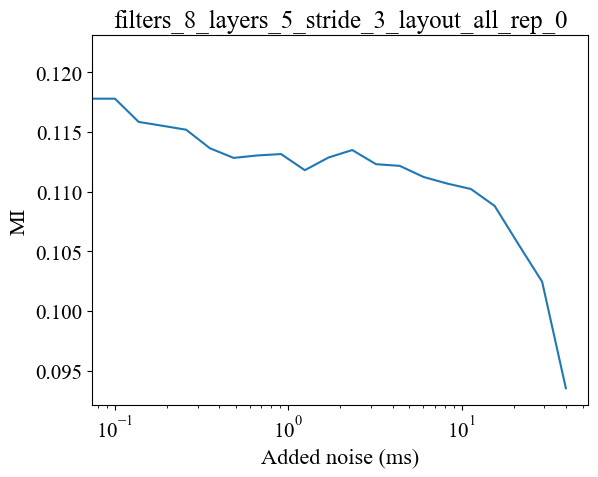

Train time = 1.0894510746002197
Test time = 0.026738882064819336
Epoch: 1, DSIB, test: 3.809406189247966e-05
Train time = 1.0747230052947998
Test time = 0.023550033569335938
Epoch: 2, DSIB, test: 0.005813523195683956
Train time = 1.0060710906982422
Test time = 0.03587079048156738
Epoch: 3, DSIB, test: 0.026426786556839943
Train time = 1.0519461631774902
Test time = 0.026717185974121094
Epoch: 4, DSIB, test: 0.03425263613462448
Train time = 1.008641004562378
Test time = 0.0569767951965332
Epoch: 5, DSIB, test: 0.026887493208050728
Train time = 1.0553100109100342
Test time = 0.02920699119567871
Epoch: 6, DSIB, test: 0.03385021165013313
Train time = 1.009617805480957
Test time = 0.06086111068725586
Epoch: 7, DSIB, test: 0.0025719802360981703
Train time = 0.9954979419708252
Test time = 0.02125096321105957
Epoch: 8, DSIB, test: -0.007873248308897018
Train time = 1.0366458892822266
Test time = 0.025600910186767578
Epoch: 9, DSIB, test: -0.0022935501765459776
Train time = 0.9963030815124512
T

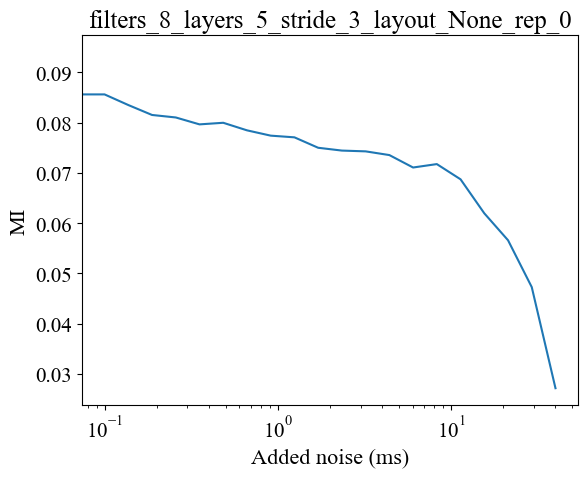

Train time = 1.1499567031860352
Test time = 0.036411285400390625
Epoch: 1, DSIB, test: 0.011122173629701138
Train time = 1.126344919204712
Test time = 0.02946305274963379
Epoch: 2, DSIB, test: 0.04775870963931084
Train time = 1.120722770690918
Test time = 0.029519081115722656
Epoch: 3, DSIB, test: 0.0503857396543026
Train time = 1.1211256980895996
Test time = 0.029423236846923828
Epoch: 4, DSIB, test: 0.06308868527412415
Train time = 1.1188158988952637
Test time = 0.02924799919128418
Epoch: 5, DSIB, test: 0.05215635150671005
Train time = 1.1225922107696533
Test time = 0.029513120651245117
Epoch: 6, DSIB, test: 0.0642440989613533
Train time = 1.1289939880371094
Test time = 0.02951979637145996
Epoch: 7, DSIB, test: 0.06806611269712448
Train time = 1.1264288425445557
Test time = 0.0303342342376709
Epoch: 8, DSIB, test: 0.06674128770828247
Train time = 1.146697998046875
Test time = 0.02998208999633789
Epoch: 9, DSIB, test: 0.0726381316781044
Train time = 1.2462852001190186
Test time = 0.03

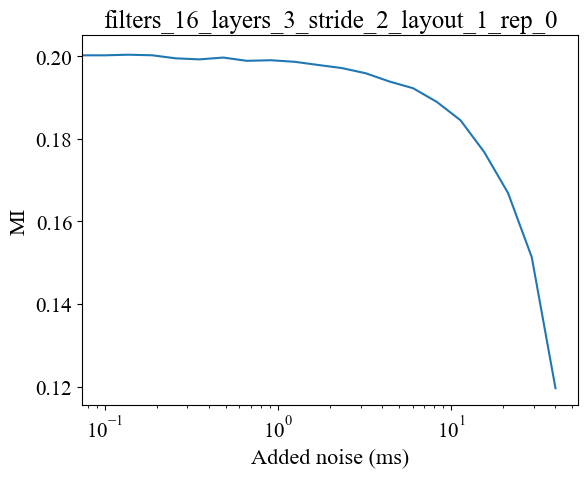

Train time = 1.3032100200653076
Test time = 0.04142403602600098
Epoch: 1, DSIB, test: 0.0015428605256602168
Train time = 1.3323471546173096
Test time = 0.04062700271606445
Epoch: 2, DSIB, test: 0.05045893043279648
Train time = 1.2967071533203125
Test time = 0.03790402412414551
Epoch: 3, DSIB, test: 0.0473402664065361
Train time = 1.306589126586914
Test time = 0.03472900390625
Epoch: 4, DSIB, test: 0.05521281436085701
Train time = 1.2881669998168945
Test time = 0.038292884826660156
Epoch: 5, DSIB, test: 0.05952858924865723
Train time = 1.3287160396575928
Test time = 0.03518390655517578
Epoch: 6, DSIB, test: 0.06199060380458832
Train time = 1.4248130321502686
Test time = 0.037856101989746094
Epoch: 7, DSIB, test: 0.07181188464164734
Train time = 1.2697699069976807
Test time = 0.03443479537963867
Epoch: 8, DSIB, test: 0.06507832556962967
Train time = 1.2929260730743408
Test time = 0.03740286827087402
Epoch: 9, DSIB, test: 0.06856752187013626
Train time = 1.3057479858398438
Test time = 0.0

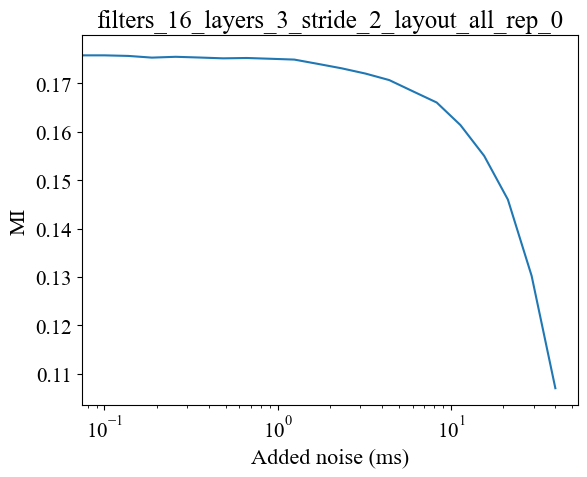

Train time = 1.2040619850158691
Test time = 0.046536922454833984
Epoch: 1, DSIB, test: 0.0010213606292381883
Train time = 1.059739112854004
Test time = 0.041509151458740234
Epoch: 2, DSIB, test: 0.05183451995253563
Train time = 1.0620198249816895
Test time = 0.0336148738861084
Epoch: 3, DSIB, test: 0.05491196736693382
Train time = 1.0573711395263672
Test time = 0.03846883773803711
Epoch: 4, DSIB, test: 0.06421171873807907
Train time = 1.0550501346588135
Test time = 0.03935885429382324
Epoch: 5, DSIB, test: 0.06669702380895615
Train time = 1.055056095123291
Test time = 0.04138803482055664
Epoch: 6, DSIB, test: 0.07425507158041
Train time = 1.0550129413604736
Test time = 0.04100298881530762
Epoch: 7, DSIB, test: 0.06756119430065155
Train time = 1.056800127029419
Test time = 0.04004383087158203
Epoch: 8, DSIB, test: 0.0698896050453186
Train time = 1.0561411380767822
Test time = 0.03780031204223633
Epoch: 9, DSIB, test: 0.07888610661029816
Train time = 1.0542268753051758
Test time = 0.0397

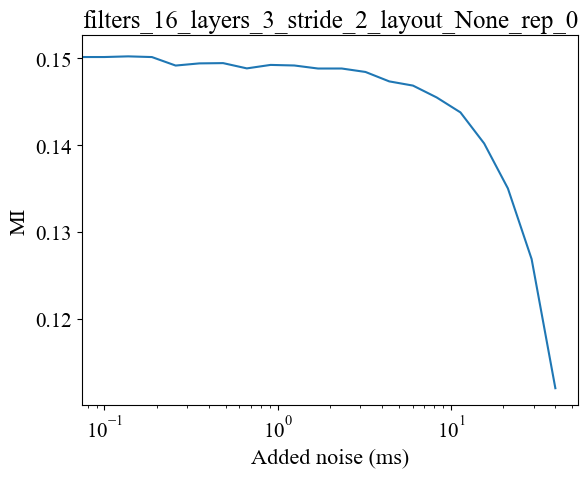

Train time = 1.1982438564300537
Test time = 0.0746150016784668
Epoch: 1, DSIB, test: 0.018544470891356468
Train time = 0.9454541206359863
Test time = 0.023211002349853516
Epoch: 2, DSIB, test: 0.0558529794216156
Train time = 0.9190878868103027
Test time = 0.023053884506225586
Epoch: 3, DSIB, test: 0.053407080471515656
Train time = 0.9429450035095215
Test time = 0.023440837860107422
Epoch: 4, DSIB, test: 0.057820700109004974
Train time = 0.930840253829956
Test time = 0.02344799041748047
Epoch: 5, DSIB, test: 0.07124093919992447
Train time = 0.9200570583343506
Test time = 0.023216962814331055
Epoch: 6, DSIB, test: 0.05851459503173828
Train time = 0.942802906036377
Test time = 0.023227214813232422
Epoch: 7, DSIB, test: 0.055540673434734344
Train time = 0.9410722255706787
Test time = 0.023198366165161133
Epoch: 8, DSIB, test: 0.0692329928278923
Train time = 0.9332451820373535
Test time = 0.023169994354248047
Epoch: 9, DSIB, test: 0.08567986637353897
Train time = 0.9426639080047607
Test tim

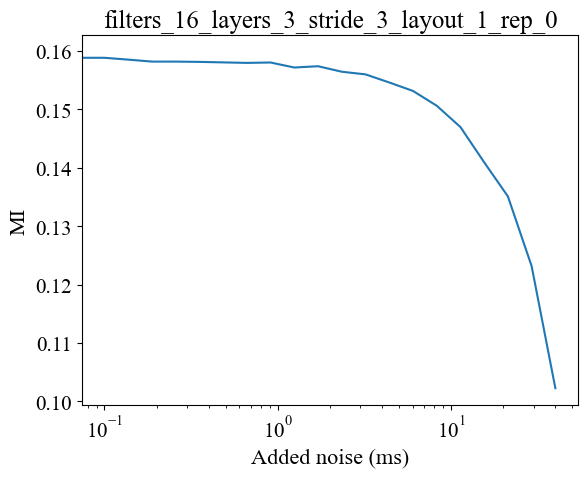

Train time = 1.4657070636749268
Test time = 0.05745983123779297
Epoch: 1, DSIB, test: 0.011179731227457523
Train time = 1.2558021545410156
Test time = 0.03738594055175781
Epoch: 2, DSIB, test: 0.02517740987241268
Train time = 1.2861838340759277
Test time = 0.035527944564819336
Epoch: 3, DSIB, test: 0.053838469088077545
Train time = 1.2609338760375977
Test time = 0.030376911163330078
Epoch: 4, DSIB, test: 0.06251396238803864
Train time = 1.2575511932373047
Test time = 0.036375999450683594
Epoch: 5, DSIB, test: 0.07414302974939346
Train time = 1.263885259628296
Test time = 0.03039407730102539
Epoch: 6, DSIB, test: 0.08281513303518295
Train time = 1.2539939880371094
Test time = 0.034790992736816406
Epoch: 7, DSIB, test: 0.06930738687515259
Train time = 1.2748217582702637
Test time = 0.03113102912902832
Epoch: 8, DSIB, test: 0.06476788222789764
Train time = 1.2747337818145752
Test time = 0.03798198699951172
Epoch: 9, DSIB, test: 0.09710697084665298
Train time = 1.2917046546936035
Test time

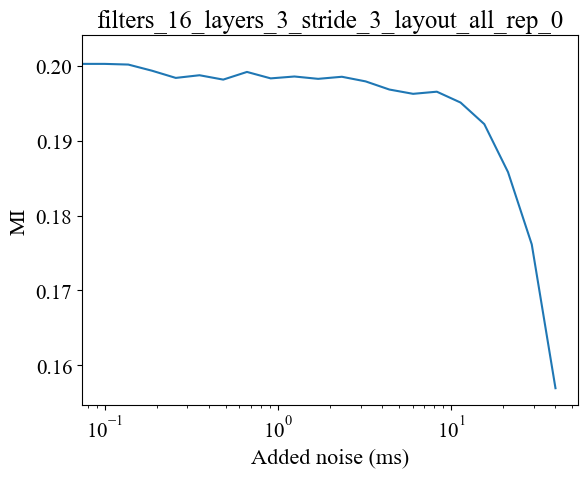

Train time = 0.8244740962982178
Test time = 0.020843029022216797
Epoch: 1, DSIB, test: 0.025328340008854866
Train time = 0.8046069145202637
Test time = 0.020631074905395508
Epoch: 2, DSIB, test: 0.04295259341597557
Train time = 0.7796459197998047
Test time = 0.02093195915222168
Epoch: 3, DSIB, test: 0.049062397330999374
Train time = 0.7912988662719727
Test time = 0.020714998245239258
Epoch: 4, DSIB, test: 0.05526989325881004
Train time = 0.7990968227386475
Test time = 0.02071380615234375
Epoch: 5, DSIB, test: 0.058963365852832794
Train time = 0.8200151920318604
Test time = 0.02077198028564453
Epoch: 6, DSIB, test: 0.06213841587305069
Train time = 0.7820870876312256
Test time = 0.020720243453979492
Epoch: 7, DSIB, test: 0.0767788216471672
Train time = 0.7942919731140137
Test time = 0.020880699157714844
Epoch: 8, DSIB, test: 0.08091546595096588
Train time = 0.8099179267883301
Test time = 0.020740032196044922
Epoch: 9, DSIB, test: 0.07871244102716446
Train time = 0.8061208724975586
Test t

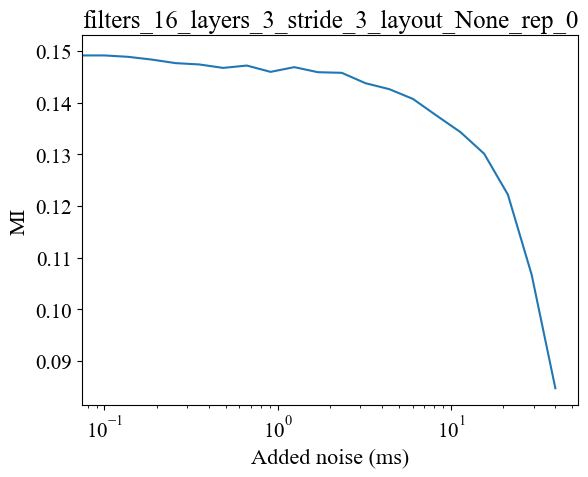

Train time = 1.5503811836242676
Test time = 0.058737993240356445
Epoch: 1, DSIB, test: 0.00021892620134167373
Train time = 1.4239428043365479
Test time = 0.036820173263549805
Epoch: 2, DSIB, test: 0.020178547129034996
Train time = 1.440633773803711
Test time = 0.040717124938964844
Epoch: 3, DSIB, test: 0.03599301353096962
Train time = 1.418637990951538
Test time = 0.03724217414855957
Epoch: 4, DSIB, test: 0.04285047575831413
Train time = 1.424530029296875
Test time = 0.04110908508300781
Epoch: 5, DSIB, test: 0.039999619126319885
Train time = 1.4205851554870605
Test time = 0.036977291107177734
Epoch: 6, DSIB, test: 0.05049585923552513
Train time = 1.4250552654266357
Test time = 0.042662858963012695
Epoch: 7, DSIB, test: 0.005968791898339987
Train time = 1.42044997215271
Test time = 0.036622047424316406
Epoch: 8, DSIB, test: 0.0673777386546135
Train time = 1.4232888221740723
Test time = 0.041078805923461914
Epoch: 9, DSIB, test: 0.06001659110188484
Train time = 1.418900966644287
Test tim

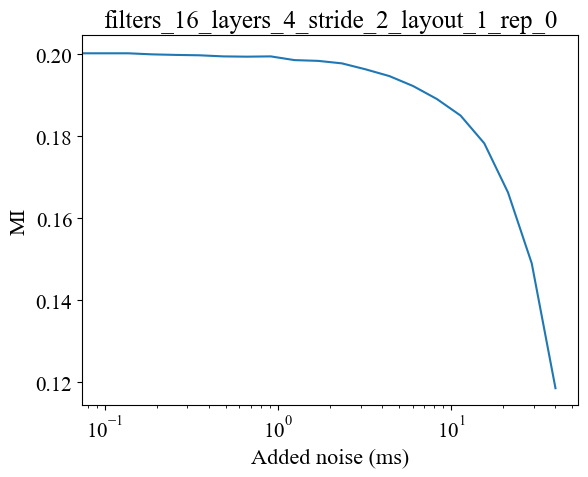

Train time = 1.7645249366760254
Test time = 0.06447100639343262
Epoch: 1, DSIB, test: 0.0038348441012203693
Train time = 1.6420660018920898
Test time = 0.05657219886779785
Epoch: 2, DSIB, test: 0.013428996317088604
Train time = 1.5933849811553955
Test time = 0.05725407600402832
Epoch: 3, DSIB, test: 0.03396008536219597
Train time = 1.6068711280822754
Test time = 0.05897021293640137
Epoch: 4, DSIB, test: 0.060305867344141006
Train time = 1.6237192153930664
Test time = 0.05877184867858887
Epoch: 5, DSIB, test: 0.08156164735555649
Train time = 1.5979747772216797
Test time = 0.05608391761779785
Epoch: 6, DSIB, test: 0.05013299360871315
Train time = 1.6111040115356445
Test time = 0.05854177474975586
Epoch: 7, DSIB, test: 0.06103808805346489
Train time = 1.6130571365356445
Test time = 0.05811190605163574
Epoch: 8, DSIB, test: 0.09349365532398224
Train time = 1.587881326675415
Test time = 0.05729484558105469
Epoch: 9, DSIB, test: 0.11553739756345749
Train time = 1.5900781154632568
Test time =

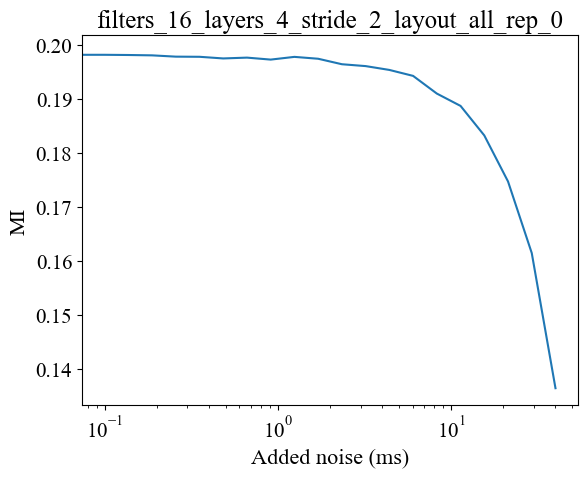

Train time = 1.4229979515075684
Test time = 0.03467392921447754
Epoch: 1, DSIB, test: 0.0023780581541359425
Train time = 1.5370800495147705
Test time = 0.04080700874328613
Epoch: 2, DSIB, test: 0.01926015131175518
Train time = 1.37162184715271
Test time = 0.03901386260986328
Epoch: 3, DSIB, test: 0.06483384966850281
Train time = 1.3674821853637695
Test time = 0.038884878158569336
Epoch: 4, DSIB, test: 0.08006660640239716
Train time = 1.3666329383850098
Test time = 0.03938579559326172
Epoch: 5, DSIB, test: 0.07226677238941193
Train time = 1.3761558532714844
Test time = 0.04000997543334961
Epoch: 6, DSIB, test: 0.09763497114181519
Train time = 1.408250093460083
Test time = 0.04027915000915527
Epoch: 7, DSIB, test: 0.11501599848270416
Train time = 1.4186551570892334
Test time = 0.03964805603027344
Epoch: 8, DSIB, test: 0.08848629891872406
Train time = 1.4137630462646484
Test time = 0.0393829345703125
Epoch: 9, DSIB, test: 0.12067238241434097
Train time = 1.4186570644378662
Test time = 0.0

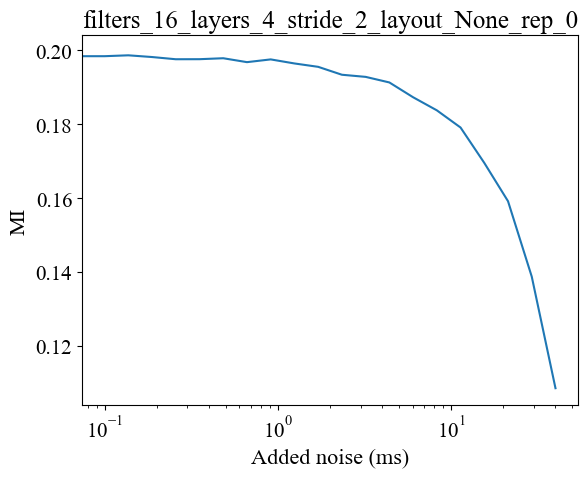

Train time = 1.4468960762023926
Test time = 0.05753612518310547
Epoch: 1, DSIB, test: 0.011793108657002449
Train time = 1.378619909286499
Test time = 0.029902935028076172
Epoch: 2, DSIB, test: 0.06598671525716782
Train time = 1.353693962097168
Test time = 0.029845237731933594
Epoch: 3, DSIB, test: 0.06212086230516434
Train time = 1.364262342453003
Test time = 0.047297000885009766
Epoch: 4, DSIB, test: 0.0739315077662468
Train time = 1.3073716163635254
Test time = 0.026870012283325195
Epoch: 5, DSIB, test: 0.07430190593004227
Train time = 1.2277140617370605
Test time = 0.028589963912963867
Epoch: 6, DSIB, test: 0.09103550016880035
Train time = 1.1856648921966553
Test time = 0.02918720245361328
Epoch: 7, DSIB, test: 0.09558872133493423
Train time = 1.130105972290039
Test time = 0.025967121124267578
Epoch: 8, DSIB, test: 0.0761641338467598
Train time = 1.095905065536499
Test time = 0.026171207427978516
Epoch: 9, DSIB, test: 0.10413103550672531
Train time = 1.1006121635437012
Test time = 0

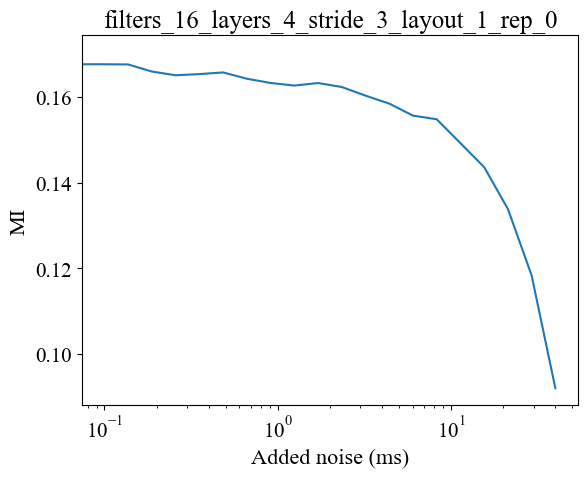

Train time = 1.9089407920837402
Test time = 0.08013200759887695
Epoch: 1, DSIB, test: 0.008558584377169609
Train time = 1.6311180591583252
Test time = 0.04610395431518555
Epoch: 2, DSIB, test: 0.03643079474568367
Train time = 1.6061689853668213
Test time = 0.0447843074798584
Epoch: 3, DSIB, test: 0.03334062919020653
Train time = 1.6468820571899414
Test time = 0.04544806480407715
Epoch: 4, DSIB, test: 0.026348277926445007
Train time = 1.8918719291687012
Test time = 0.05392313003540039
Epoch: 5, DSIB, test: 0.04639039561152458
Train time = 1.6383700370788574
Test time = 0.05564689636230469
Epoch: 6, DSIB, test: 0.024381468072533607
Train time = 1.6357731819152832
Test time = 0.05260586738586426
Epoch: 7, DSIB, test: 0.06263577938079834
Train time = 1.6670830249786377
Test time = 0.04608917236328125
Epoch: 8, DSIB, test: 0.03521594777703285
Train time = 1.692505121231079
Test time = 0.053526878356933594
Epoch: 9, DSIB, test: 0.04769926145672798
Train time = 1.6997730731964111
Test time = 

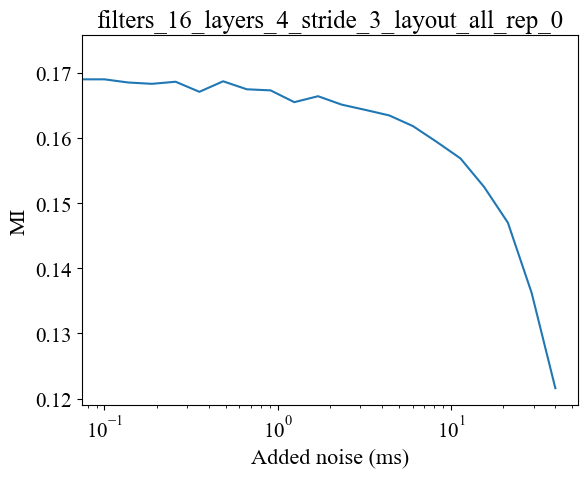

Train time = 0.9942679405212402
Test time = 0.028940200805664062
Epoch: 1, DSIB, test: 0.0021730174776166677
Train time = 1.0311901569366455
Test time = 0.03768587112426758
Epoch: 2, DSIB, test: 0.024826927110552788
Train time = 1.01242995262146
Test time = 0.024537086486816406
Epoch: 3, DSIB, test: 0.06161533668637276
Train time = 0.9619238376617432
Test time = 0.02441692352294922
Epoch: 4, DSIB, test: 0.05892295762896538
Train time = 1.0174241065979004
Test time = 0.04914379119873047
Epoch: 5, DSIB, test: 0.079832524061203
Train time = 0.9651997089385986
Test time = 0.02661609649658203
Epoch: 6, DSIB, test: 0.0895698145031929
Train time = 1.1767432689666748
Test time = 0.03406977653503418
Epoch: 7, DSIB, test: 0.0851474180817604
Train time = 1.1667540073394775
Test time = 0.024097919464111328
Epoch: 8, DSIB, test: 0.03804778680205345
Train time = 1.0851600170135498
Test time = 0.03126120567321777
Epoch: 9, DSIB, test: 0.072868712246418
Train time = 0.9981811046600342
Test time = 0.02

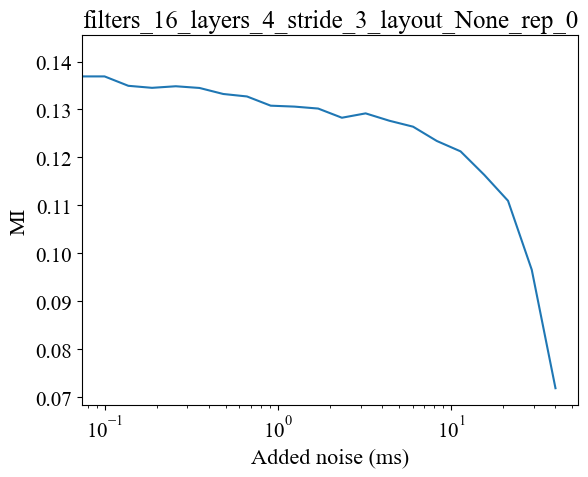

Train time = 2.17568302154541
Test time = 0.06973004341125488
Epoch: 1, DSIB, test: 0.0003039544099010527
Train time = 1.9510328769683838
Test time = 0.045881032943725586
Epoch: 2, DSIB, test: -0.00023075580247677863
Train time = 1.9488649368286133
Test time = 0.04962778091430664
Epoch: 3, DSIB, test: -0.0003741137043107301
Train time = 1.9144649505615234
Test time = 0.04588007926940918
Epoch: 4, DSIB, test: 0.0012589961988851428
Train time = 1.8989360332489014
Test time = 0.04748201370239258
Epoch: 5, DSIB, test: 0.00018807666492648423
Train time = 1.929466962814331
Test time = 0.045923709869384766
Epoch: 6, DSIB, test: 0.006245345808565617
Train time = 1.8857450485229492
Test time = 0.051836252212524414
Epoch: 7, DSIB, test: 0.03047891892492771
Train time = 1.9192986488342285
Test time = 0.04578375816345215
Epoch: 8, DSIB, test: 0.05281388387084007
Train time = 1.8610761165618896
Test time = 0.0461268424987793
Epoch: 9, DSIB, test: 0.054895367473363876
Train time = 1.948470115661621


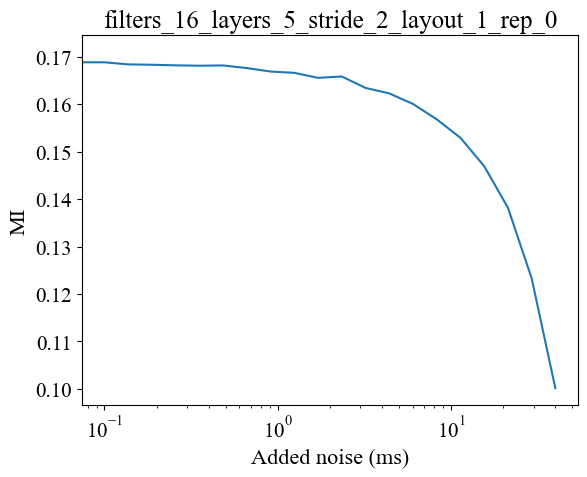

Train time = 2.320266008377075
Test time = 0.08875393867492676
Epoch: 1, DSIB, test: 0.004976755008101463
Train time = 2.1097400188446045
Test time = 0.06627297401428223
Epoch: 2, DSIB, test: 0.004626847337931395
Train time = 2.0603318214416504
Test time = 0.0658271312713623
Epoch: 3, DSIB, test: 0.039486128836870193
Train time = 2.106645107269287
Test time = 0.08565998077392578
Epoch: 4, DSIB, test: 0.07240154594182968
Train time = 2.0947530269622803
Test time = 0.06868672370910645
Epoch: 5, DSIB, test: 0.08792152255773544
Train time = 2.1975438594818115
Test time = 0.09669876098632812
Epoch: 6, DSIB, test: 0.08946552872657776
Train time = 2.2012720108032227
Test time = 0.07853913307189941
Epoch: 7, DSIB, test: 0.11154742538928986
Train time = 2.0703072547912598
Test time = 0.07083511352539062
Epoch: 8, DSIB, test: 0.11283554136753082
Train time = 2.0618269443511963
Test time = 0.06893301010131836
Epoch: 9, DSIB, test: 0.12810972332954407
Train time = 2.087773323059082
Test time = 0.0

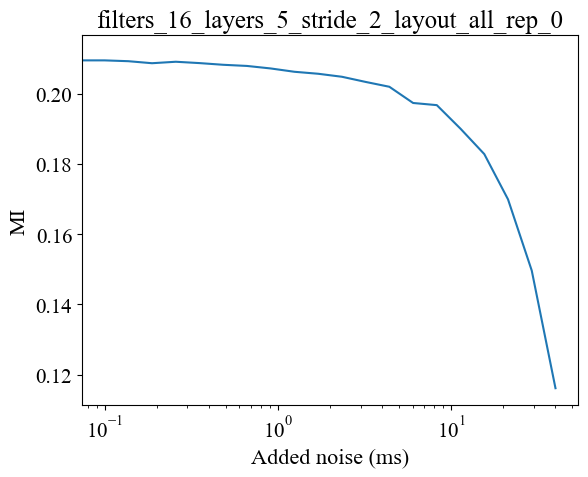

Train time = 1.804042100906372
Test time = 0.05480504035949707
Epoch: 1, DSIB, test: 0.0006993248243816197
Train time = 1.7974600791931152
Test time = 0.04776191711425781
Epoch: 2, DSIB, test: -0.0009217463666573167
Train time = 1.7966911792755127
Test time = 0.04850506782531738
Epoch: 3, DSIB, test: 0.0038183974102139473
Train time = 1.8005790710449219
Test time = 0.04837608337402344
Epoch: 4, DSIB, test: 0.0007734588580206037
Train time = 1.9733307361602783
Test time = 0.05115985870361328
Epoch: 5, DSIB, test: 0.0362318754196167
Train time = 1.811891794204712
Test time = 0.051400184631347656
Epoch: 6, DSIB, test: 0.045069530606269836
Train time = 1.8084080219268799
Test time = 0.04835677146911621
Epoch: 7, DSIB, test: 0.06477080285549164
Train time = 1.8073618412017822
Test time = 0.05093884468078613
Epoch: 8, DSIB, test: 0.07871390134096146
Train time = 1.8240137100219727
Test time = 0.052423954010009766
Epoch: 9, DSIB, test: 0.09873558580875397
Train time = 1.8195018768310547
Test 

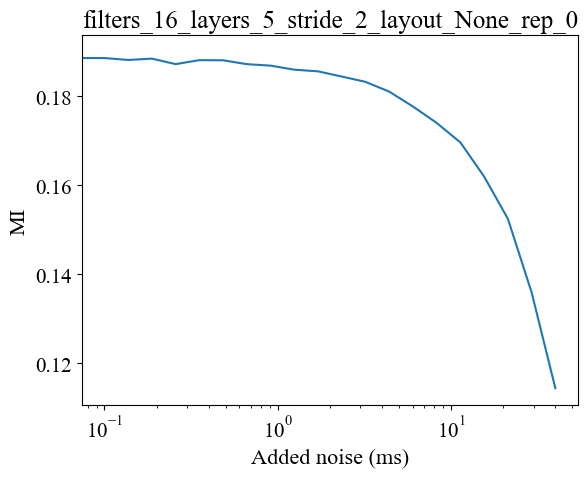

Train time = 1.4450600147247314
Test time = 0.05139517784118652
Epoch: 1, DSIB, test: -0.0018103793263435364
Train time = 1.3332300186157227
Test time = 0.03516578674316406
Epoch: 2, DSIB, test: -0.0029329692479223013
Train time = 1.3185207843780518
Test time = 0.036743879318237305
Epoch: 3, DSIB, test: 0.0012260018847882748
Train time = 1.3210561275482178
Test time = 0.03517293930053711
Epoch: 4, DSIB, test: -0.0014841037336736917
Train time = 1.3153669834136963
Test time = 0.03528118133544922
Epoch: 5, DSIB, test: 0.04126095026731491
Train time = 1.287261962890625
Test time = 0.035189151763916016
Epoch: 6, DSIB, test: 0.0692809522151947
Train time = 1.2806799411773682
Test time = 0.03528189659118652
Epoch: 7, DSIB, test: 0.0663323625922203
Train time = 1.2910771369934082
Test time = 0.03523087501525879
Epoch: 8, DSIB, test: 0.08002915233373642
Train time = 1.3252520561218262
Test time = 0.035245656967163086
Epoch: 9, DSIB, test: 0.05604672059416771
Train time = 1.3611299991607666
Tes

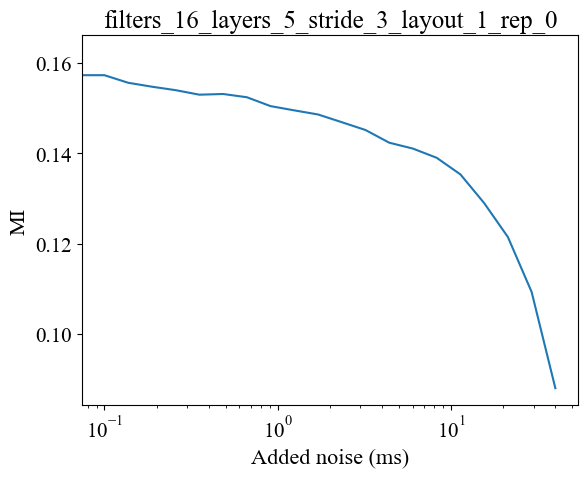

Train time = 1.9604301452636719
Test time = 0.06943488121032715
Epoch: 1, DSIB, test: 0.005606488790363073
Train time = 1.8998379707336426
Test time = 0.06433701515197754
Epoch: 2, DSIB, test: 0.01905684359371662
Train time = 1.873075008392334
Test time = 0.0612637996673584
Epoch: 3, DSIB, test: 0.04133540019392967
Train time = 1.860520839691162
Test time = 0.06209373474121094
Epoch: 4, DSIB, test: 0.05962337553501129
Train time = 1.7999401092529297
Test time = 0.06057000160217285
Epoch: 5, DSIB, test: 0.05009222775697708
Train time = 1.8318259716033936
Test time = 0.06105780601501465
Epoch: 6, DSIB, test: -0.012154893949627876
Train time = 1.8347852230072021
Test time = 0.0628349781036377
Epoch: 7, DSIB, test: 0.061345361173152924
Train time = 1.9394688606262207
Test time = 0.07367396354675293
Epoch: 8, DSIB, test: 0.03206600621342659
Train time = 1.9762609004974365
Test time = 0.07325196266174316
Epoch: 9, DSIB, test: 0.029607079923152924
Train time = 1.9990692138671875
Test time = 0

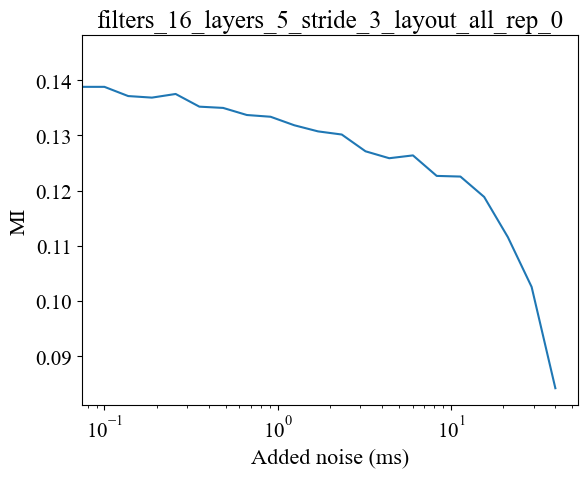

Train time = 1.3063631057739258
Test time = 0.03507208824157715
Epoch: 1, DSIB, test: 0.0014117724495008588
Train time = 1.19694185256958
Test time = 0.03261995315551758
Epoch: 2, DSIB, test: 0.0031859518494457006
Train time = 1.222991943359375
Test time = 0.03518104553222656
Epoch: 3, DSIB, test: 0.020047800615429878
Train time = 1.213348150253296
Test time = 0.03272128105163574
Epoch: 4, DSIB, test: 0.03428810089826584
Train time = 1.3641438484191895
Test time = 0.03300213813781738
Epoch: 5, DSIB, test: 0.05554261803627014
Train time = 1.2271549701690674
Test time = 0.03310799598693848
Epoch: 6, DSIB, test: 0.03876315802335739
Train time = 1.2206499576568604
Test time = 0.033019065856933594
Epoch: 7, DSIB, test: 0.011357889510691166
Train time = 1.2007076740264893
Test time = 0.03299999237060547
Epoch: 8, DSIB, test: 0.020681358873844147
Train time = 1.2031941413879395
Test time = 0.032885074615478516
Epoch: 9, DSIB, test: -0.00416466174647212
Train time = 1.2164812088012695
Test tim

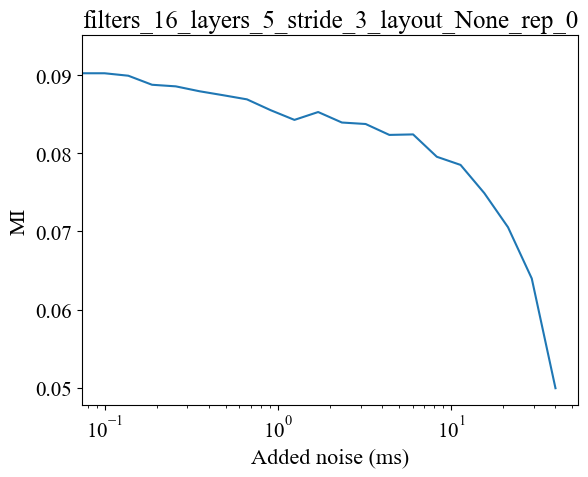

Train time = 2.6660759449005127
Test time = 0.10103607177734375
Epoch: 1, DSIB, test: 0.003451904747635126
Train time = 2.3803889751434326
Test time = 0.07385492324829102
Epoch: 2, DSIB, test: 0.04913114756345749
Train time = 2.3830277919769287
Test time = 0.08104515075683594
Epoch: 3, DSIB, test: 0.04636727273464203
Train time = 2.4023079872131348
Test time = 0.07709813117980957
Epoch: 4, DSIB, test: 0.05927008390426636
Train time = 2.3922207355499268
Test time = 0.07563591003417969
Epoch: 5, DSIB, test: 0.064527727663517
Train time = 2.383134126663208
Test time = 0.07505607604980469
Epoch: 6, DSIB, test: 0.07605297863483429
Train time = 2.3794028759002686
Test time = 0.07826590538024902
Epoch: 7, DSIB, test: 0.08850347250699997
Train time = 2.3799257278442383
Test time = 0.07733297348022461
Epoch: 8, DSIB, test: 0.07672334462404251
Train time = 2.3856539726257324
Test time = 0.07767987251281738
Epoch: 9, DSIB, test: 0.07455016672611237
Train time = 2.377228021621704
Test time = 0.074

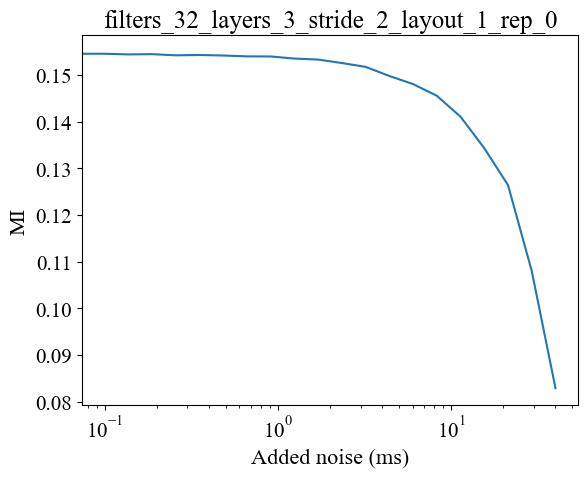

Train time = 2.8679990768432617
Test time = 0.09055209159851074
Epoch: 1, DSIB, test: -0.01974577084183693
Train time = 2.614445924758911
Test time = 0.08266115188598633
Epoch: 2, DSIB, test: 0.021988267078995705
Train time = 2.6069319248199463
Test time = 0.082733154296875
Epoch: 3, DSIB, test: 0.05945120379328728
Train time = 2.611042022705078
Test time = 0.07947492599487305
Epoch: 4, DSIB, test: 0.06709401309490204
Train time = 2.608610153198242
Test time = 0.08623409271240234
Epoch: 5, DSIB, test: 0.0506703220307827
Train time = 2.608116865158081
Test time = 0.07899785041809082
Epoch: 6, DSIB, test: 0.07423462718725204
Train time = 2.6071701049804688
Test time = 0.08081603050231934
Epoch: 7, DSIB, test: 0.06954639405012131
Train time = 2.609333038330078
Test time = 0.07903671264648438
Epoch: 8, DSIB, test: 0.06359291076660156
Train time = 2.6046998500823975
Test time = 0.07933425903320312
Epoch: 9, DSIB, test: 0.053575899451971054
Train time = 2.6060540676116943
Test time = 0.07937

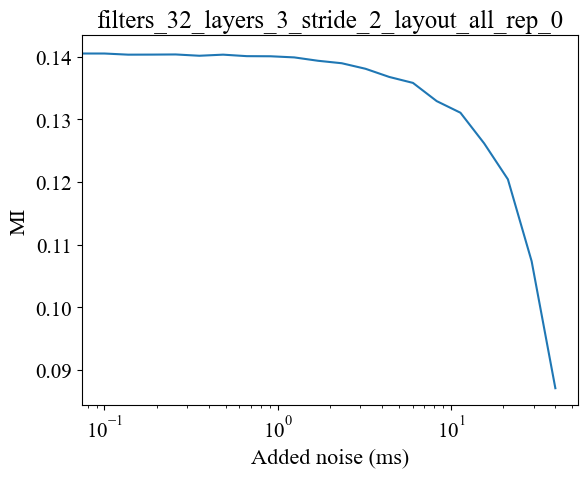

Train time = 2.4172000885009766
Test time = 0.0709831714630127
Epoch: 1, DSIB, test: 0.00606646528467536
Train time = 2.3246378898620605
Test time = 0.06882786750793457
Epoch: 2, DSIB, test: 0.05341077223420143
Train time = 2.3200860023498535
Test time = 0.06913471221923828
Epoch: 3, DSIB, test: 0.06148475781083107
Train time = 2.320531129837036
Test time = 0.06862282752990723
Epoch: 4, DSIB, test: 0.05450250580906868
Train time = 2.315890073776245
Test time = 0.06932806968688965
Epoch: 5, DSIB, test: 0.06477946788072586
Train time = 2.3185269832611084
Test time = 0.0693979263305664
Epoch: 6, DSIB, test: 0.07928480952978134
Train time = 2.315502166748047
Test time = 0.06897306442260742
Epoch: 7, DSIB, test: 0.0877193883061409
Train time = 2.3164732456207275
Test time = 0.0688788890838623
Epoch: 8, DSIB, test: 0.06867154687643051
Train time = 2.316348075866699
Test time = 0.0684201717376709
Epoch: 9, DSIB, test: 0.09198687225580215
Train time = 2.317171096801758
Test time = 0.0691998004

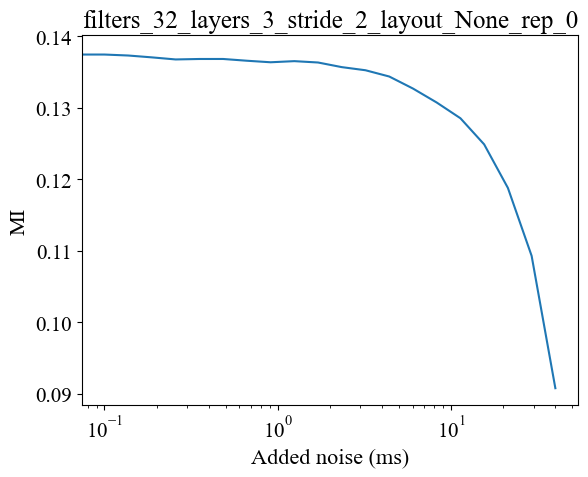

Train time = 1.8127686977386475
Test time = 0.08057808876037598
Epoch: 1, DSIB, test: 0.00679948041215539
Train time = 1.5782861709594727
Test time = 0.05314207077026367
Epoch: 2, DSIB, test: -0.012223165482282639
Train time = 1.5748610496520996
Test time = 0.05306601524353027
Epoch: 3, DSIB, test: 0.0383199006319046
Train time = 1.5754420757293701
Test time = 0.053488969802856445
Epoch: 4, DSIB, test: 0.06733378022909164
Train time = 1.574911117553711
Test time = 0.053107261657714844
Epoch: 5, DSIB, test: 0.07021786272525787
Train time = 1.6831529140472412
Test time = 0.05488014221191406
Epoch: 6, DSIB, test: 0.08136125653982162
Train time = 1.5903019905090332
Test time = 0.05470395088195801
Epoch: 7, DSIB, test: 0.08444645255804062
Train time = 1.5798289775848389
Test time = 0.05359315872192383
Epoch: 8, DSIB, test: 0.08576863259077072
Train time = 1.580862045288086
Test time = 0.05318403244018555
Epoch: 9, DSIB, test: 0.050978075712919235
Train time = 1.5831801891326904
Test time = 

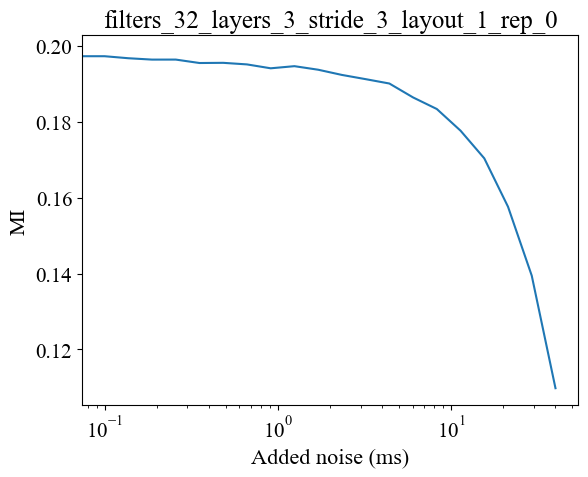

Train time = 2.106435775756836
Test time = 0.08092403411865234
Epoch: 1, DSIB, test: -0.0002499162219464779
Train time = 2.036911964416504
Test time = 0.06747913360595703
Epoch: 2, DSIB, test: 0.024954257532954216
Train time = 1.8079321384429932
Test time = 0.063201904296875
Epoch: 3, DSIB, test: 0.006223476957529783
Train time = 1.826289176940918
Test time = 0.059535980224609375
Epoch: 4, DSIB, test: 0.03224008530378342
Train time = 1.7890830039978027
Test time = 0.05984687805175781
Epoch: 5, DSIB, test: 0.05559686943888664
Train time = 1.8071649074554443
Test time = 0.05981326103210449
Epoch: 6, DSIB, test: 0.05957827344536781
Train time = 1.7893750667572021
Test time = 0.06036996841430664
Epoch: 7, DSIB, test: 0.05564083158969879
Train time = 1.7942509651184082
Test time = 0.06173896789550781
Epoch: 8, DSIB, test: 0.06401874125003815
Train time = 1.801558017730713
Test time = 0.060415029525756836
Epoch: 9, DSIB, test: 0.07720950245857239
Train time = 1.8066349029541016
Test time = 0

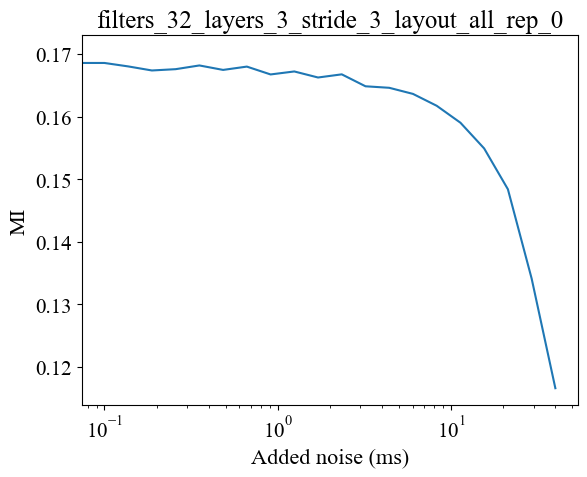

Train time = 1.5328009128570557
Test time = 0.06331992149353027
Epoch: 1, DSIB, test: 0.005466689355671406
Train time = 1.5082290172576904
Test time = 0.04669690132141113
Epoch: 2, DSIB, test: 0.03427274897694588
Train time = 1.5048801898956299
Test time = 0.048795223236083984
Epoch: 3, DSIB, test: 0.03699614107608795
Train time = 1.4968540668487549
Test time = 0.04857802391052246
Epoch: 4, DSIB, test: 0.043346650898456573
Train time = 1.4948506355285645
Test time = 0.04877281188964844
Epoch: 5, DSIB, test: 0.04761391133069992
Train time = 1.5068590641021729
Test time = 0.04911303520202637
Epoch: 6, DSIB, test: 0.05145411193370819
Train time = 1.5004987716674805
Test time = 0.04938697814941406
Epoch: 7, DSIB, test: 0.048304468393325806
Train time = 1.4919168949127197
Test time = 0.04736804962158203
Epoch: 8, DSIB, test: 0.0186320673674345
Train time = 1.5011117458343506
Test time = 0.04866194725036621
Epoch: 9, DSIB, test: 0.06404590606689453
Train time = 1.6391770839691162
Test time =

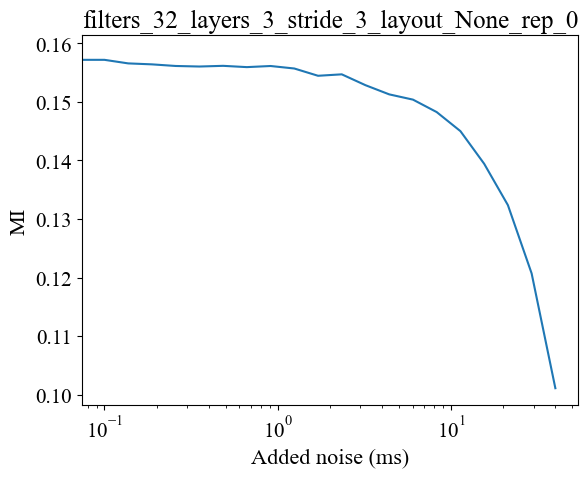

Train time = 3.557133913040161
Test time = 0.0938270092010498
Epoch: 1, DSIB, test: 0.001151909469626844
Train time = 3.3988709449768066
Test time = 0.11057424545288086
Epoch: 2, DSIB, test: -0.0008042535628192127
Train time = 3.4324679374694824
Test time = 0.1006772518157959
Epoch: 3, DSIB, test: -0.000795855070464313
Train time = 3.4128849506378174
Test time = 0.09936189651489258
Epoch: 4, DSIB, test: 0.0021779686212539673
Train time = 3.4008290767669678
Test time = 0.10030794143676758
Epoch: 5, DSIB, test: 0.006378678604960442
Train time = 3.5012712478637695
Test time = 0.09969472885131836
Epoch: 6, DSIB, test: 0.021273523569107056
Train time = 3.4047791957855225
Test time = 0.09904623031616211
Epoch: 7, DSIB, test: 0.06105279177427292
Train time = 3.4061548709869385
Test time = 0.10070610046386719
Epoch: 8, DSIB, test: 0.054691482335329056
Train time = 3.399885892868042
Test time = 0.10000801086425781
Epoch: 9, DSIB, test: 0.06710140407085419
Train time = 3.405876874923706
Test tim

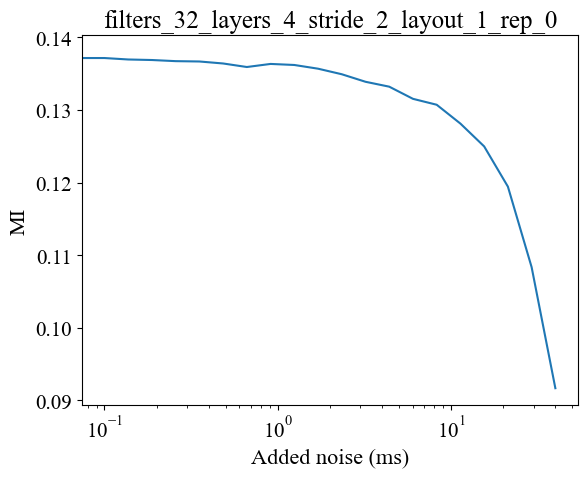

Train time = 3.8672070503234863
Test time = 0.10876703262329102
Epoch: 1, DSIB, test: 0.001416343729943037
Train time = 3.740778923034668
Test time = 0.11696290969848633
Epoch: 2, DSIB, test: -0.008114364929497242
Train time = 3.746324062347412
Test time = 0.10976099967956543
Epoch: 3, DSIB, test: 0.00423755869269371
Train time = 3.7442848682403564
Test time = 0.10757613182067871
Epoch: 4, DSIB, test: 0.06601674854755402
Train time = 3.7502169609069824
Test time = 0.10698795318603516
Epoch: 5, DSIB, test: 0.07291766256093979
Train time = 3.742583751678467
Test time = 0.10722112655639648
Epoch: 6, DSIB, test: 0.08031020313501358
Train time = 3.7712979316711426
Test time = 0.16216111183166504
Epoch: 7, DSIB, test: 0.06616085022687912
Train time = 3.946589231491089
Test time = 0.1195070743560791
Epoch: 8, DSIB, test: 0.098141610622406
Train time = 4.0927629470825195
Test time = 0.11742496490478516
Epoch: 9, DSIB, test: 0.10879145562648773
Train time = 3.806696891784668
Test time = 0.11044

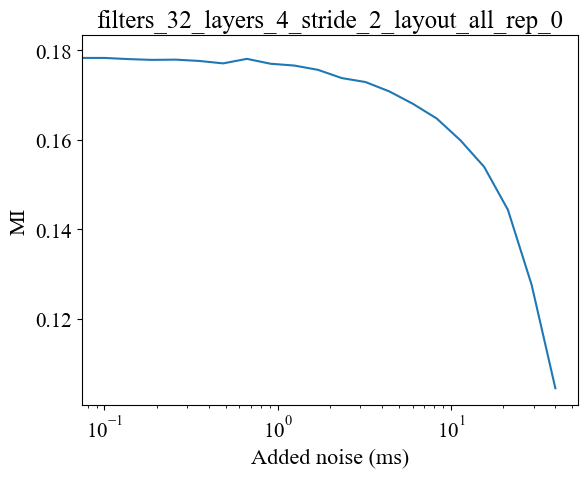

Train time = 3.379667043685913
Test time = 0.0956878662109375
Epoch: 1, DSIB, test: 0.00025011904654093087
Train time = 3.366163969039917
Test time = 0.09458303451538086
Epoch: 2, DSIB, test: -0.012698949314653873
Train time = 3.36228084564209
Test time = 0.0943758487701416
Epoch: 3, DSIB, test: -0.0012766971485689282
Train time = 3.3612890243530273
Test time = 0.09408307075500488
Epoch: 4, DSIB, test: 0.02522645704448223
Train time = 3.365514039993286
Test time = 0.0935511589050293
Epoch: 5, DSIB, test: 0.05428224429488182
Train time = 3.3652570247650146
Test time = 0.09587407112121582
Epoch: 6, DSIB, test: 0.06322624534368515
Train time = 3.364208936691284
Test time = 0.0943899154663086
Epoch: 7, DSIB, test: 0.03210019692778587
Train time = 3.3637261390686035
Test time = 0.09376406669616699
Epoch: 8, DSIB, test: 0.08034723252058029
Train time = 3.3638319969177246
Test time = 0.09469270706176758
Epoch: 9, DSIB, test: 0.0567731149494648
Train time = 3.359405040740967
Test time = 0.0937

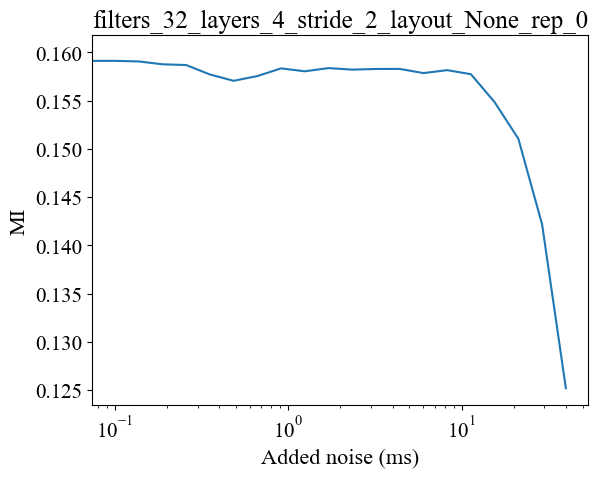

Train time = 2.0980453491210938
Test time = 0.0589601993560791
Epoch: 1, DSIB, test: -0.00012506423809099942
Train time = 1.963202953338623
Test time = 0.0585939884185791
Epoch: 2, DSIB, test: 0.026615729555487633
Train time = 1.9696152210235596
Test time = 0.06506705284118652
Epoch: 3, DSIB, test: 0.03910671919584274
Train time = 1.9611587524414062
Test time = 0.05867123603820801
Epoch: 4, DSIB, test: 0.04861580207943916
Train time = 1.9677586555480957
Test time = 0.06554293632507324
Epoch: 5, DSIB, test: 0.05389200896024704
Train time = 1.962846040725708
Test time = 0.058499813079833984
Epoch: 6, DSIB, test: 0.0615532211959362
Train time = 1.9658489227294922
Test time = 0.06647610664367676
Epoch: 7, DSIB, test: 0.05160510540008545
Train time = 1.9607481956481934
Test time = 0.058461904525756836
Epoch: 8, DSIB, test: 0.07501833885908127
Train time = 1.9664990901947021
Test time = 0.06593799591064453
Epoch: 9, DSIB, test: 0.07392995059490204
Train time = 1.9679107666015625
Test time = 

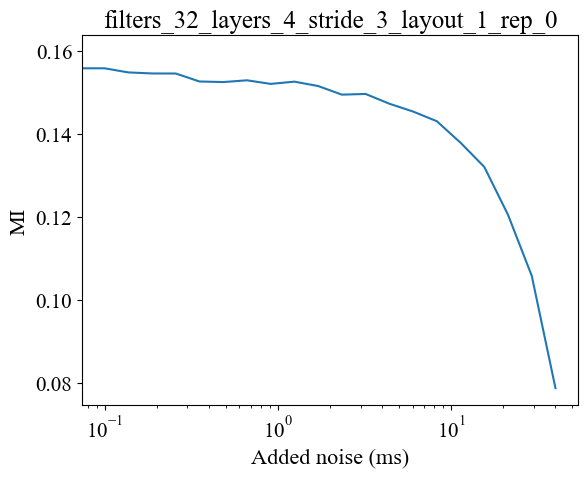

Train time = 2.448357105255127
Test time = 0.07373809814453125
Epoch: 1, DSIB, test: 0.007482725195586681
Train time = 2.2577788829803467
Test time = 0.07318305969238281
Epoch: 2, DSIB, test: 0.06828545778989792
Train time = 2.254260778427124
Test time = 0.07260012626647949
Epoch: 3, DSIB, test: 0.06866782903671265
Train time = 2.259226083755493
Test time = 0.06668806076049805
Epoch: 4, DSIB, test: 0.05722977593541145
Train time = 2.255945920944214
Test time = 0.07293391227722168
Epoch: 5, DSIB, test: 0.09600307047367096
Train time = 2.2653250694274902
Test time = 0.0661168098449707
Epoch: 6, DSIB, test: 0.12414562702178955
Train time = 2.2527389526367188
Test time = 0.07194399833679199
Epoch: 7, DSIB, test: 0.08090712130069733
Train time = 2.251008987426758
Test time = 0.0726938247680664
Epoch: 8, DSIB, test: 0.11201337724924088
Train time = 2.2606427669525146
Test time = 0.0666189193725586
Epoch: 9, DSIB, test: 0.12666134536266327
Train time = 2.2504708766937256
Test time = 0.0728158

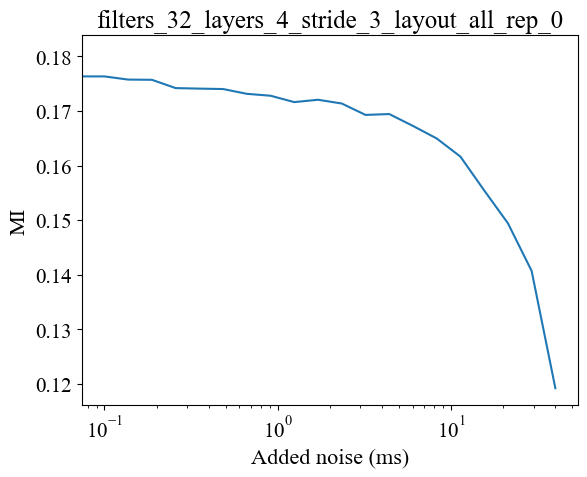

Train time = 1.9166059494018555
Test time = 0.056845664978027344
Epoch: 1, DSIB, test: 0.0036582783795893192
Train time = 1.910742998123169
Test time = 0.05725717544555664
Epoch: 2, DSIB, test: 0.01584569737315178
Train time = 1.9009368419647217
Test time = 0.057260990142822266
Epoch: 3, DSIB, test: 0.034567926079034805
Train time = 1.900418996810913
Test time = 0.056993961334228516
Epoch: 4, DSIB, test: 0.038062989711761475
Train time = 1.9009170532226562
Test time = 0.0573422908782959
Epoch: 5, DSIB, test: 0.05133805423974991
Train time = 1.9000499248504639
Test time = 0.057554006576538086
Epoch: 6, DSIB, test: 0.036119502037763596
Train time = 1.903393030166626
Test time = 0.05730295181274414
Epoch: 7, DSIB, test: 0.04622281715273857
Train time = 1.8977131843566895
Test time = 0.0580439567565918
Epoch: 8, DSIB, test: 0.04892246797680855
Train time = 2.063098192214966
Test time = 0.057051897048950195
Epoch: 9, DSIB, test: 0.058859389275312424
Train time = 1.901947021484375
Test time 

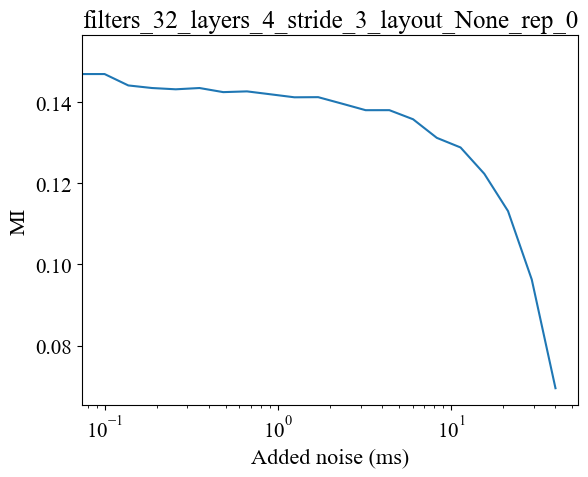

Train time = 5.180538177490234
Test time = 0.12502288818359375
Epoch: 1, DSIB, test: 0.00023371634597424418
Train time = 4.9613258838653564
Test time = 0.13154196739196777
Epoch: 2, DSIB, test: 0.0015804468421265483
Train time = 4.953131914138794
Test time = 0.1298532485961914
Epoch: 3, DSIB, test: 0.0036613920237869024
Train time = 4.9545838832855225
Test time = 0.12928318977355957
Epoch: 4, DSIB, test: 0.004106495995074511
Train time = 4.956333637237549
Test time = 0.12898802757263184
Epoch: 5, DSIB, test: 0.007965213619172573
Train time = 4.953774929046631
Test time = 0.12939190864562988
Epoch: 6, DSIB, test: 0.02123090997338295
Train time = 4.9546849727630615
Test time = 0.13109374046325684
Epoch: 7, DSIB, test: 0.04744858667254448
Train time = 4.955306053161621
Test time = 0.1298811435699463
Epoch: 8, DSIB, test: 0.05160575732588768
Train time = 4.954540967941284
Test time = 0.1297931671142578
Epoch: 9, DSIB, test: 0.05021991953253746
Train time = 4.955620050430298
Test time = 0.1

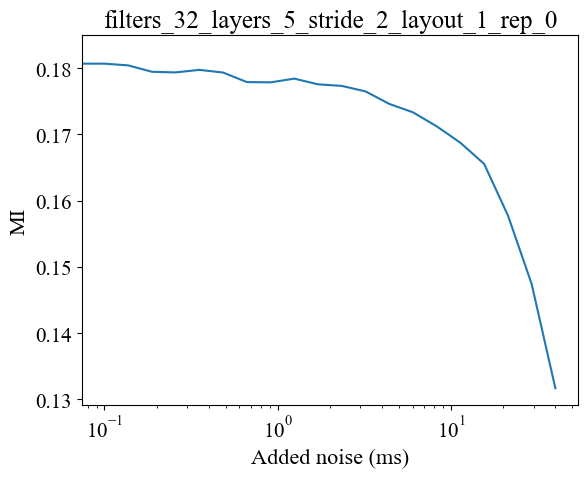

Train time = 5.691924095153809
Test time = 0.14056396484375
Epoch: 1, DSIB, test: -0.0008870720630511642
Train time = 5.3171610832214355
Test time = 0.14204812049865723
Epoch: 2, DSIB, test: 0.0030729572754353285
Train time = 5.316326141357422
Test time = 0.1412668228149414
Epoch: 3, DSIB, test: -0.0016943045193329453
Train time = 5.313783168792725
Test time = 0.14072585105895996
Epoch: 4, DSIB, test: 0.003766821464523673
Train time = 5.345371961593628
Test time = 0.15455913543701172
Epoch: 5, DSIB, test: 0.036413319408893585
Train time = 5.312159299850464
Test time = 0.1402740478515625
Epoch: 6, DSIB, test: 0.05233025923371315
Train time = 5.311067342758179
Test time = 0.140639066696167
Epoch: 7, DSIB, test: 0.09360694885253906
Train time = 5.311487197875977
Test time = 0.14019203186035156
Epoch: 8, DSIB, test: 0.08130796998739243
Train time = 5.310102939605713
Test time = 0.14007282257080078
Epoch: 9, DSIB, test: 0.06743359565734863
Train time = 5.317293167114258
Test time = 0.150607

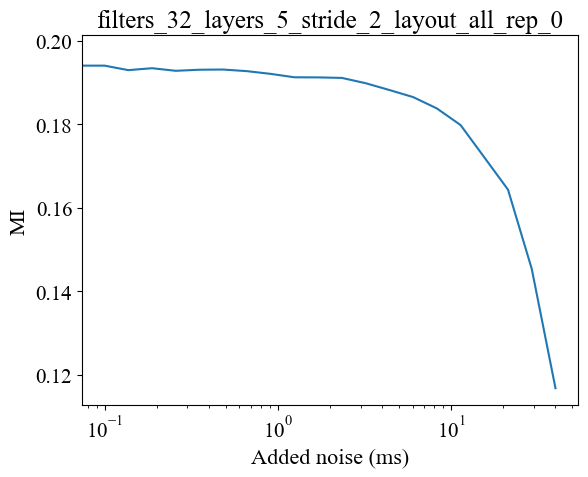

Train time = 4.951284170150757
Test time = 0.12735819816589355
Epoch: 1, DSIB, test: -0.004873672034591436
Train time = 4.938115119934082
Test time = 0.12607598304748535
Epoch: 2, DSIB, test: -3.0419943868764676e-05
Train time = 4.896113872528076
Test time = 0.12389206886291504
Epoch: 3, DSIB, test: 3.356316301506013e-05
Train time = 4.8817360401153564
Test time = 0.12368488311767578
Epoch: 4, DSIB, test: 0.00017641462909523398
Train time = 4.880293130874634
Test time = 0.12405610084533691
Epoch: 5, DSIB, test: 0.0026157775428146124
Train time = 5.042314052581787
Test time = 0.12699079513549805
Epoch: 6, DSIB, test: 0.0504317581653595
Train time = 4.885878086090088
Test time = 0.12678122520446777
Epoch: 7, DSIB, test: 0.045369651168584824
Train time = 4.88100790977478
Test time = 0.1236429214477539
Epoch: 8, DSIB, test: 0.053336966782808304
Train time = 4.879299640655518
Test time = 0.12291097640991211
Epoch: 9, DSIB, test: 0.06445182114839554
Train time = 4.8790459632873535
Test time 

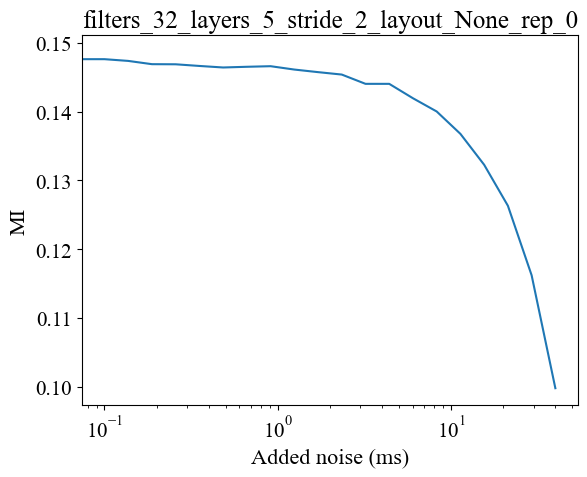

Train time = 2.6479060649871826
Test time = 0.08663415908813477
Epoch: 1, DSIB, test: -0.001990030985325575
Train time = 2.516373872756958
Test time = 0.09290003776550293
Epoch: 2, DSIB, test: -0.0006316309445537627
Train time = 2.514569044113159
Test time = 0.09099507331848145
Epoch: 3, DSIB, test: -2.65403650701046e-05
Train time = 2.512204885482788
Test time = 0.09044384956359863
Epoch: 4, DSIB, test: -0.0012792829656973481
Train time = 2.5128180980682373
Test time = 0.09134817123413086
Epoch: 5, DSIB, test: 0.0013301721774041653
Train time = 2.5203070640563965
Test time = 0.09475374221801758
Epoch: 6, DSIB, test: -0.001450497074984014
Train time = 2.51701021194458
Test time = 0.0907127857208252
Epoch: 7, DSIB, test: -0.0014202087186276913
Train time = 2.516645908355713
Test time = 0.0908360481262207
Epoch: 8, DSIB, test: 0.005253302399069071
Train time = 2.5220448970794678
Test time = 0.09225177764892578
Epoch: 9, DSIB, test: 0.0224546380341053
Train time = 2.5210020542144775
Test 

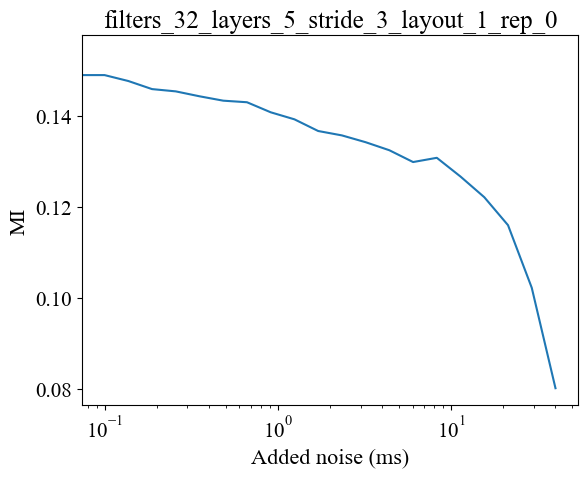

Train time = 3.0373036861419678
Test time = 0.0973351001739502
Epoch: 1, DSIB, test: 0.0033332896418869495
Train time = 2.8874449729919434
Test time = 0.10353302955627441
Epoch: 2, DSIB, test: 0.004759392235428095
Train time = 2.8873379230499268
Test time = 0.10311698913574219
Epoch: 3, DSIB, test: 0.012348247691988945
Train time = 2.8872830867767334
Test time = 0.10349106788635254
Epoch: 4, DSIB, test: 0.035403747111558914
Train time = 2.8919050693511963
Test time = 0.10429191589355469
Epoch: 5, DSIB, test: 0.04497453570365906
Train time = 2.889115810394287
Test time = 0.10355806350708008
Epoch: 6, DSIB, test: 0.07510209828615189
Train time = 2.8850901126861572
Test time = 0.10286808013916016
Epoch: 7, DSIB, test: 0.09591832011938095
Train time = 2.88132381439209
Test time = 0.10290884971618652
Epoch: 8, DSIB, test: 0.07461666315793991
Train time = 2.8840339183807373
Test time = 0.10310602188110352
Epoch: 9, DSIB, test: 0.08828136324882507
Train time = 2.888307809829712
Test time = 0.

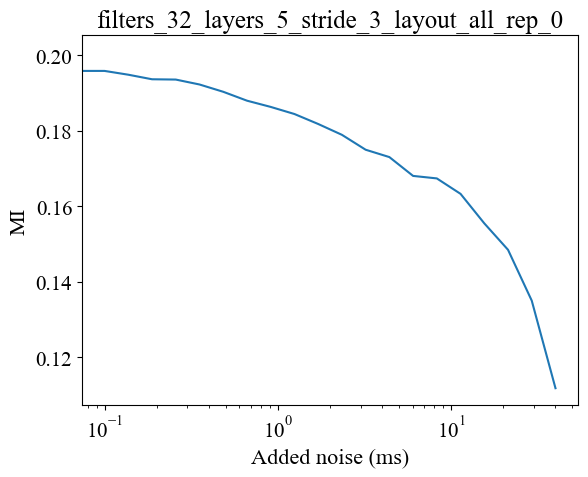

Train time = 2.4629781246185303
Test time = 0.09301304817199707
Epoch: 1, DSIB, test: -0.005282582715153694
Train time = 2.453665018081665
Test time = 0.08485198020935059
Epoch: 2, DSIB, test: -0.0029785283841192722
Train time = 2.617110013961792
Test time = 0.08558893203735352
Epoch: 3, DSIB, test: -0.00578271085396409
Train time = 2.445706844329834
Test time = 0.08484721183776855
Epoch: 4, DSIB, test: -0.008955742232501507
Train time = 2.44856595993042
Test time = 0.08608889579772949
Epoch: 5, DSIB, test: -0.010423770174384117
Train time = 2.4444732666015625
Test time = 0.08631491661071777
Epoch: 6, DSIB, test: -0.0024565120693296194
Train time = 2.4436709880828857
Test time = 0.08611416816711426
Epoch: 7, DSIB, test: -0.003127465955913067
Train time = 2.4434471130371094
Test time = 0.08521080017089844
Epoch: 8, DSIB, test: 0.0013025390217080712
Train time = 2.4442169666290283
Test time = 0.08614802360534668
Epoch: 9, DSIB, test: -0.00478313397616148
Train time = 2.450129747390747
Te

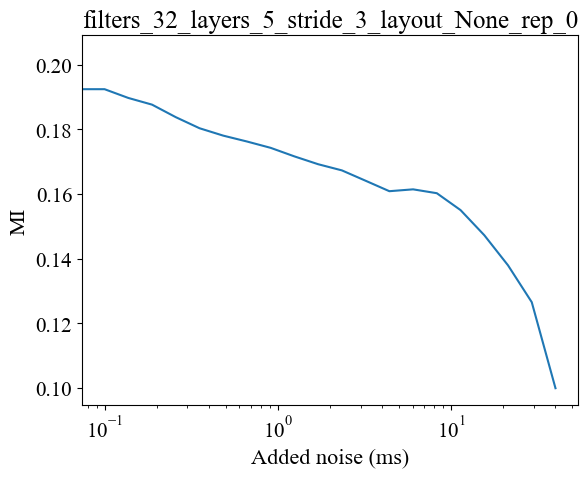

In [ ]:
filter_range = np.array([8, 16, 32])
layers_range = np.array([3,4,5])
stride_range = np.array([2,3])
branch_range = ['1', 'all', None]
repeats_range = np.arange(1)

precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3

neuron = 25
dataset_neuron = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])

train_ids = {}
precision_curves = {}
models = {}
time_per_epoch = {}

for n_filters, n_layers, n_stride, branch_layout, rep in product(filter_range, layers_range, stride_range, branch_range, repeats_range):
    torch.mps.empty_cache()
    # Reset to zero noise
    dataset_neuron.apply_noise(0)
    # dataset_all.apply_noise(0)
    this_params = {**params, 'branch': branch_layout, 'stride': n_stride, 'n_filters': n_filters, 'layers': n_layers}
    # Train model on single neuron
    torch.mps.synchronize()
    tic = time.time()
    mis_test, train_id = train_cnn_model_no_eval(dataset_neuron, this_params, model_cache_dir)
    thistime = time.time() - tic
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    with torch.no_grad():
        # Estimate precision on this model
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset_neuron.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset_neuron.X, dataset_neuron.Y).detach().cpu().numpy()
        # Save results
        key = f'filters_{n_filters}_layers_{n_layers}_stride_{n_stride}_layout_{str(branch_layout)}_rep_{rep}'
        train_ids[key] = train_id
        models[key] = mod
        precision_curves[key] = precision_mi
        time_per_epoch[key] = thistime / len(mis_test)
        # Plot precision result
        fig, ax = plt.subplots()
        ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
        ax.set_xscale('log')
        ax.set_xlabel('Added noise (ms)')
        ax.set_ylabel('MI')
        ax.set_title(key)
        plt.show()


# Precision


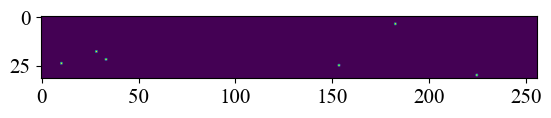

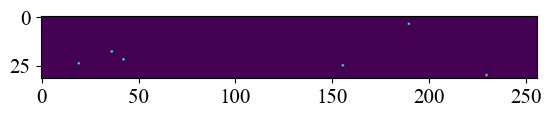

In [64]:
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['batch_size'])

plt.figure()
dataset.apply_noise(0)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())
plt.figure()
dataset.apply_noise(0.001 / period)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())

In [ ]:
torch.cuda.empty_cache()
mod.eval()
amts = np.linspace(100,1500,10, dtype=int)
vals = np.zeros_like(amts)
with torch.no_grad():
    for i,amt in enumerate(amts):
        dataset.apply_noise(0)
        inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), amt)
        vals[i] = - mod(dataset.Xnoise[inds,:,:,:], dataset.Ynoise[inds,:,:,:])
plt.plot(amts, vals)

In [8]:
torch.mps.empty_cache()

# this_params = {**params, 'embed_dim': 10, 'window_size': 256}
torch.mps.synchronize()
tic = time.time()
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['window_size'])
torch.mps.synchronize()
print(f'dataset = {time.time() - tic}')

n_repeats = 3
# noise_levels = torch.arange(period, 20*period, step=period).to(device)
noise_levels = torch.logspace(np.log10(period), np.log10(0.02), 20).to(device)
precision_mi = torch.zeros((len(noise_levels), n_repeats)).to(device)

mod.eval()

with torch.no_grad():
    for i,amp in enumerate(noise_levels):
        for j in range(n_repeats):
            dataset.apply_noise(amp / period)

            # inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), 2000)
            torch.mps.synchronize()
            tic = time.time()
            precision_mi[i,j] = -models[0](dataset.Xnoise, dataset.Ynoise).detach()
            torch.mps.synchronize()
            print(f'Inference: {time.time() - tic}')


dataset = 0.15633583068847656
Inference: 0.5941340923309326
Inference: 0.6205008029937744
Inference: 0.5042769908905029
Inference: 0.49620890617370605
Inference: 0.49607014656066895
Inference: 0.49566197395324707
Inference: 0.5053088665008545
Inference: 0.5037403106689453
Inference: 0.49646592140197754
Inference: 0.5309922695159912
Inference: 0.5017919540405273
Inference: 0.5031547546386719
Inference: 0.5056519508361816
Inference: 0.5065462589263916
Inference: 0.5328259468078613
Inference: 0.5059599876403809
Inference: 0.5154757499694824
Inference: 0.5013079643249512
Inference: 0.4972820281982422
Inference: 0.49623584747314453
Inference: 0.49387693405151367
Inference: 0.4951040744781494
Inference: 0.5004711151123047
Inference: 0.49389219284057617
Inference: 0.5356400012969971
Inference: 0.5194571018218994
Inference: 0.5167787075042725
Inference: 0.5145699977874756
Inference: 0.5240731239318848
Inference: 0.5170049667358398
Inference: 0.51226806640625
Inference: 0.5134811401367188
Infer

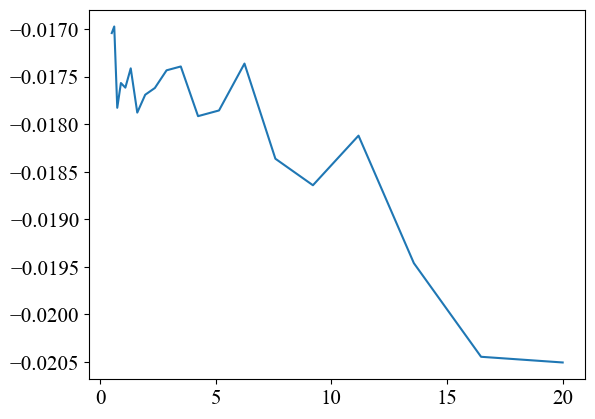

In [9]:
plt.plot(noise_levels.cpu() * 1000, torch.mean(precision_mi, dim=1).cpu())
# plt.gca().set_xscale('log')

# Precision estimation via training (not inference)

Re-training the model with different amounts of noise applied to the data

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 1e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 5,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period = 0.0005
noise_range = np.hstack((0, np.logspace(np.log10(period), np.log10(0.01), 10) / period))
mi = np.zeros_like(np.array(noise_range))
mi_test = []
models = []
ids = []
# Precision curve params
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 5
precision_curves = []

X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

for i,noise_amp in enumerate(noise_range):
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval_apply_noise(dataset, this_params, model_cache_dir, noise_amp)
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    # Run inference
    with torch.no_grad():
        dataset.apply_noise(noise_amp)
        thismi = - mod(dataset.Xnoise, dataset.Ynoise)
        mi[i] = thismi.detach().cpu()
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Train time = 1.280348777770996
Test time = 0.154494047164917
Epoch: 1, DSIB, test: 0.1166582778096199
Train time = 1.273681879043579
Test time = 0.04385209083557129
Epoch: 2, DSIB, test: 0.18439489603042603
Train time = 1.2437896728515625
Test time = 0.0436711311340332
Epoch: 3, DSIB, test: 0.1823572814464569
Train time = 1.2447450160980225
Test time = 0.04325294494628906
Epoch: 4, DSIB, test: 0.23784030973911285
Train time = 1.2418811321258545
Test time = 0.044243812561035156
Epoch: 5, DSIB, test: 0.2471899688243866
Train time = 1.244704008102417
Test time = 0.04499697685241699
Epoch: 6, DSIB, test: 0.20079758763313293
Train time = 1.2425282001495361
Test time = 0.04319000244140625
Epoch: 7, DSIB, test: 0.11532793939113617
Train time = 1.2433910369873047
Test time = 0.04400205612182617
Epoch: 8, DSIB, test: 0.14835144579410553
Train time = 1.2450592517852783
Test time = 0.044033050537109375
Epoch: 9, DSIB, test: -0.09854907542467117
Train time = 1.2392871379852295
Test time = 0.044008

Text(0, 0.5, 'MI (bits/s)')

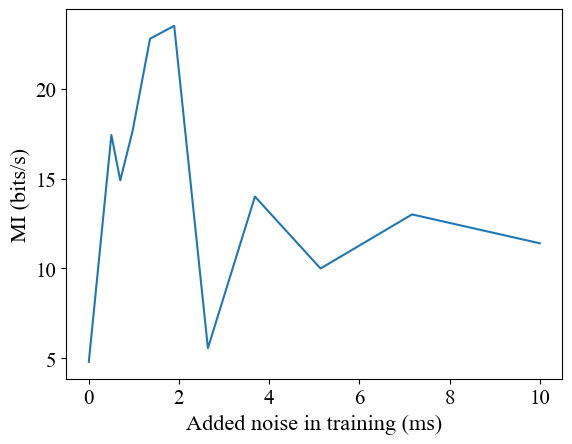

In [93]:
torch.mps.empty_cache()
plt.plot(noise_range * period * 1000, mi * np.log2(np.e) / params['window_size'] / period)
plt.gca().set_xlabel('Added noise in training (ms)')
plt.gca().set_ylabel('MI (bits/s)')

Text(0, 0.5, 'Measured precision (ms)')

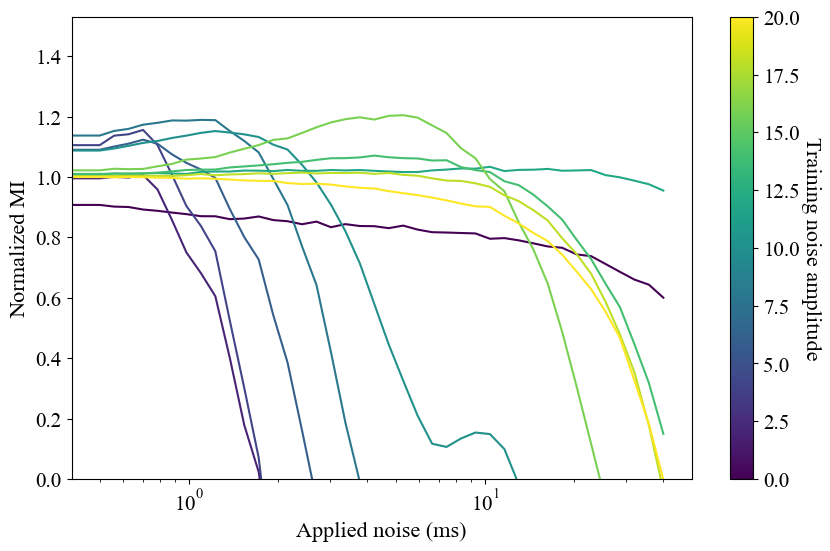

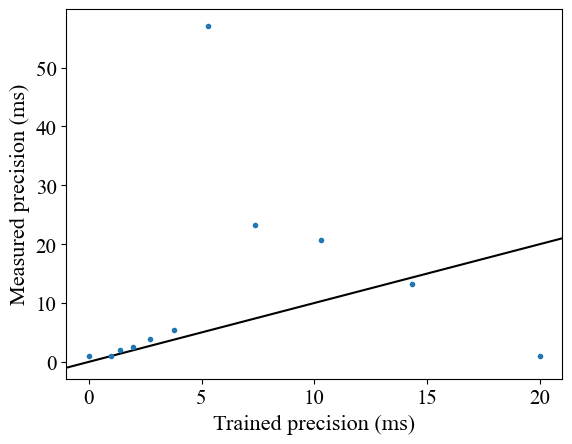

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis')
for i in range(len(noise_range)):
    color_pos = i / (len(noise_range) - 1) if len(noise_range) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels * period * 1000, vals / vals[0], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=noise_range[-1]))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Training noise amplitude', rotation=270, labelpad=15)
ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

fig, ax = plt.subplots()
precision = []
for curve in precision_curves:
    val = np.mean(curve, axis=1)
    val = val / val[0]
    precision.append(precision_noise_levels[np.argmax(val < 1)])

ax.axline([0,0], slope=1, color='k')
ax.plot(noise_range, np.array(precision),'.')
ax.set_xlabel('Trained precision (ms)')
ax.set_ylabel('Measured precision (ms)')

Text(0, 0.5, 'Normalized MI')

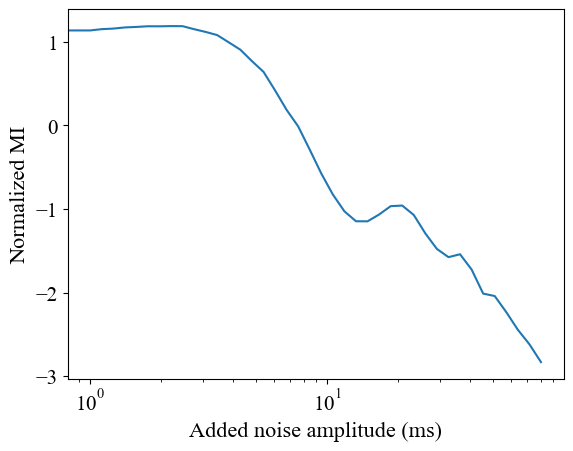

In [118]:
curve = np.mean(precision_curves[4], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

# Vary dataset binning, see how it changes information learned/found

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'embed_dim': 10,
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period_range = np.logspace(np.log10(0.00005), np.log10(0.01), 20)
mi_test = []
models = []
ids = []
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    print(f'Period = {period} s')
    X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
    X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
    torch.mps.empty_cache()
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval(dataset, params, model_cache_dir)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    with torch.no_grad():
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Period = 4.9999999999999996e-05 s
Train time = 8.385380744934082
Test time = 0.21169400215148926
Epoch: 1, DSIB, test: 0.006829846650362015
Train time = 7.9879150390625
Test time = 0.2163081169128418
Epoch: 2, DSIB, test: 0.03982722386717796
Train time = 7.946149826049805
Test time = 0.2069230079650879
Epoch: 3, DSIB, test: 0.03663326054811478
Train time = 7.95436692237854
Test time = 0.20759916305541992
Epoch: 4, DSIB, test: 0.04140667989850044
Train time = 7.903834342956543
Test time = 0.20545005798339844
Epoch: 5, DSIB, test: 0.04298585280776024
Train time = 7.910940885543823
Test time = 0.2080216407775879
Epoch: 6, DSIB, test: 0.03641291707754135
Train time = 7.91900110244751
Test time = 0.20574522018432617
Epoch: 7, DSIB, test: 0.03459368646144867
Train time = 7.93487286567688
Test time = 0.2082958221435547
Epoch: 8, DSIB, test: 0.035471778362989426
Train time = 7.982103109359741
Test time = 0.20671892166137695
Epoch: 9, DSIB, test: 0.04286494106054306
Train time = 7.9067850112915

In [32]:
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    with torch.no_grad():
        X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
        X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
        torch.mps.empty_cache()
        precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - models[i](dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)

Text(0, 0.5, 'MI (bits/s)')

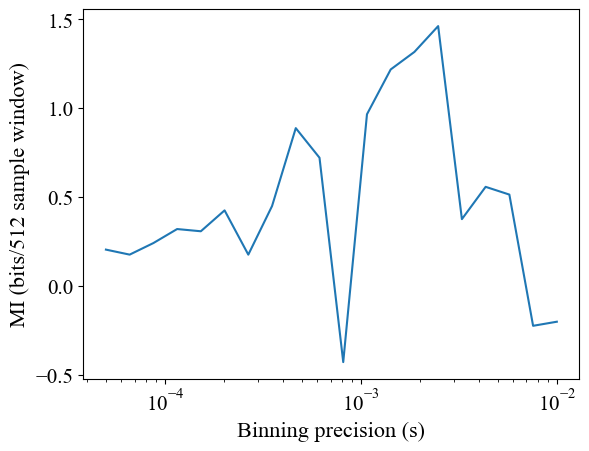

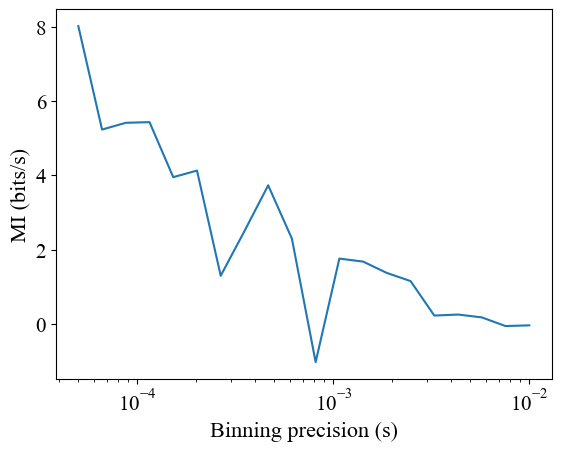

In [19]:
mi = np.array([np.mean(p[0,:]) for p in precision_curves])
plt.plot(np.array(period_range), mi * np.log2(np.e))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/512 sample window)')

plt.figure()
plt.plot(np.array(period_range), mi * np.log2(np.e) / params['window_size'] / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/s)')

In [42]:
period_range * 1000

array([ 0.05      ,  0.06608104,  0.08733407,  0.11542251,  0.15254479,
        0.20160635,  0.26644714,  0.35214206,  0.46539824,  0.61507997,
        0.81290243,  1.07434871,  1.41988152,  1.87654485,  2.48008057,
        3.2777259 ,  4.33191049,  5.7251427 ,  7.56646728, 10.        ])

Text(0, 0.5, 'Normalized MI')

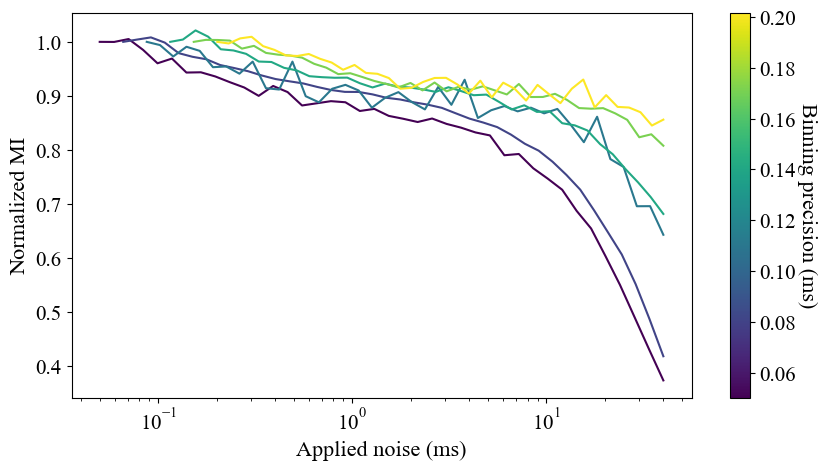

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.get_cmap('viridis')
prange = period_range[0:6]
for i, period in enumerate(prange):
    precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40)))
    color_pos = i / (len(prange) - 1) if len(prange) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels[1:] * 1000, vals[1:] / vals[1], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=prange[0]*1000, vmax=prange[-1]*1000))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Binning precision (ms)', rotation=270, labelpad=15)
ax.set_xscale('log')
# ax.set_ylim()
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

Text(0, 0.5, 'Normalized MI')

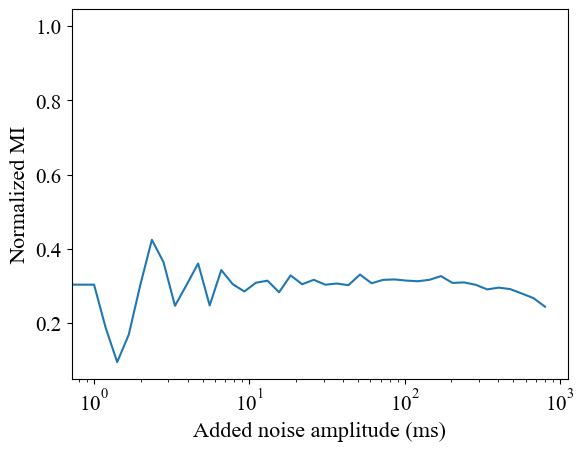

In [18]:
curve = np.mean(precision_curves[0], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

KeyError: 'trial_0_dz_1_bs_20'

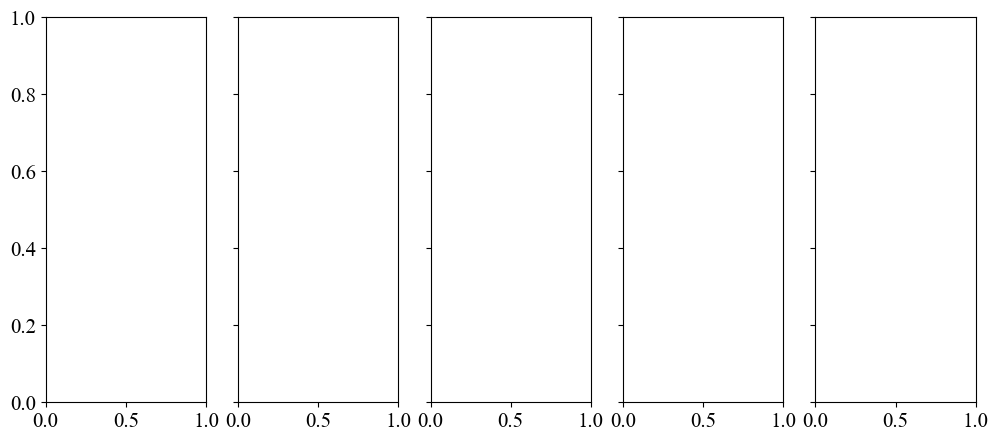

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


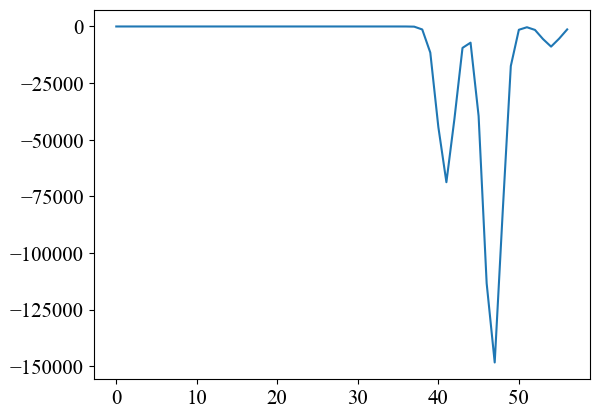

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes